# ML Simulation Deep Validation Notebook

This notebook provides comprehensive tools for validating the ML simulation process at a granular level. It allows inspection of individual patient journeys through the entire pipeline to understand exactly how predictions are generated and why certain performance metrics are achieved.

## Purpose

This notebook was created to investigate potential issues with ML simulation performance, particularly when the system achieves unexpectedly high sensitivity (~80%) and PPV (~30%). By examining individual patients and each transformation step, we can identify where the simulation might be producing unrealistic results.

## Key Features

1. **Patient-Level Deep Dive**: Track individual patients through the entire pipeline
2. **Step-by-Step Validation**: Examine each transformation in the prediction process
3. **Mathematical Verification**: Validate calculations at each stage
4. **Error Analysis**: Identify patterns in prediction errors
5. **Interactive Exploration**: Select different patients and parameters for analysis

## Validation Sections

- Section 1: Setup and Data Generation
- Section 2: Individual Patient Inspection
- Section 3: Risk Integration Validation
- Section 4: ML Prediction Generation Analysis
- Section 5: Performance Metrics Deep Dive
- Section 6: Error Pattern Analysis
- Section 7: Interactive Validation Tools

## 1. Setup and Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import sys
import os

# Add src directory to path for imports
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import all necessary functions
from pop_ml_simulator import (
    # Risk distribution
    assign_patient_risks, simulate_annual_incidents,
    # Temporal dynamics
    build_temporal_risk_matrix, EnhancedTemporalRiskSimulator,
    # Risk integration
    integrate_window_risk, extract_risk_windows, validate_integration_bounds,
    # ML simulation
    MLPredictionSimulator, generate_temporal_ml_predictions,
    validate_temporal_sensitivity, benchmark_temporal_ml_performance,
    evaluate_threshold_based, evaluate_topk,
    # Hazard modeling
    IncidentGenerator
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All imports successful!")
print("🔬 Ready for deep ML validation...")

✅ All imports successful!
🔬 Ready for deep ML validation...


In [2]:
# Generate test population
n_patients = 1000  # Smaller for detailed analysis
n_timesteps = 52  # One year of weekly data
annual_incident_rate = 0.12
concentration = 0.5

# Generate base patient risks
print("Generating patient population...")
base_risks = assign_patient_risks(
    n_patients, 
    annual_incident_rate=annual_incident_rate,
    concentration=concentration,
    random_seed=42
)

print(f"Patient population: {n_patients:,}")
print(f"Mean base risk: {np.mean(base_risks):.1%}")
print(f"Risk range: [{np.min(base_risks):.3f}, {np.max(base_risks):.3f}]")

# Build temporal risk matrix
print("\nBuilding temporal risk matrix...")
temporal_matrix = build_temporal_risk_matrix(
    base_risks,
    n_timesteps=n_timesteps,
    rho=0.9,  # High temporal correlation
    sigma=0.12,  # Moderate volatility
    temporal_bounds=(0.3, 2.0),
    seasonal_amplitude=0.15,  # 15% seasonal variation
    seasonal_period=52,  # Annual cycle
    random_seed=42
)

print(f"Temporal matrix shape: {temporal_matrix.shape}")
print(f"Temporal risk range: [{np.min(temporal_matrix):.3f}, {np.max(temporal_matrix):.3f}]")

# Define prediction window
prediction_start = 20
window_length = 12

print(f"\nPrediction window: weeks {prediction_start} to {prediction_start + window_length}")

Generating patient population...
Patient population: 1,000
Mean base risk: 12.0%
Risk range: [0.000, 0.946]

Building temporal risk matrix...
Temporal matrix shape: (1000, 52)
Temporal risk range: [0.000, 0.950]

Prediction window: weeks 20 to 32


## 2. Individual Patient Deep Dive

Let's examine specific patients in detail to understand their journey through the ML prediction pipeline.

Analyzing random patients without ML predictions first...

Analyzing Patient 616


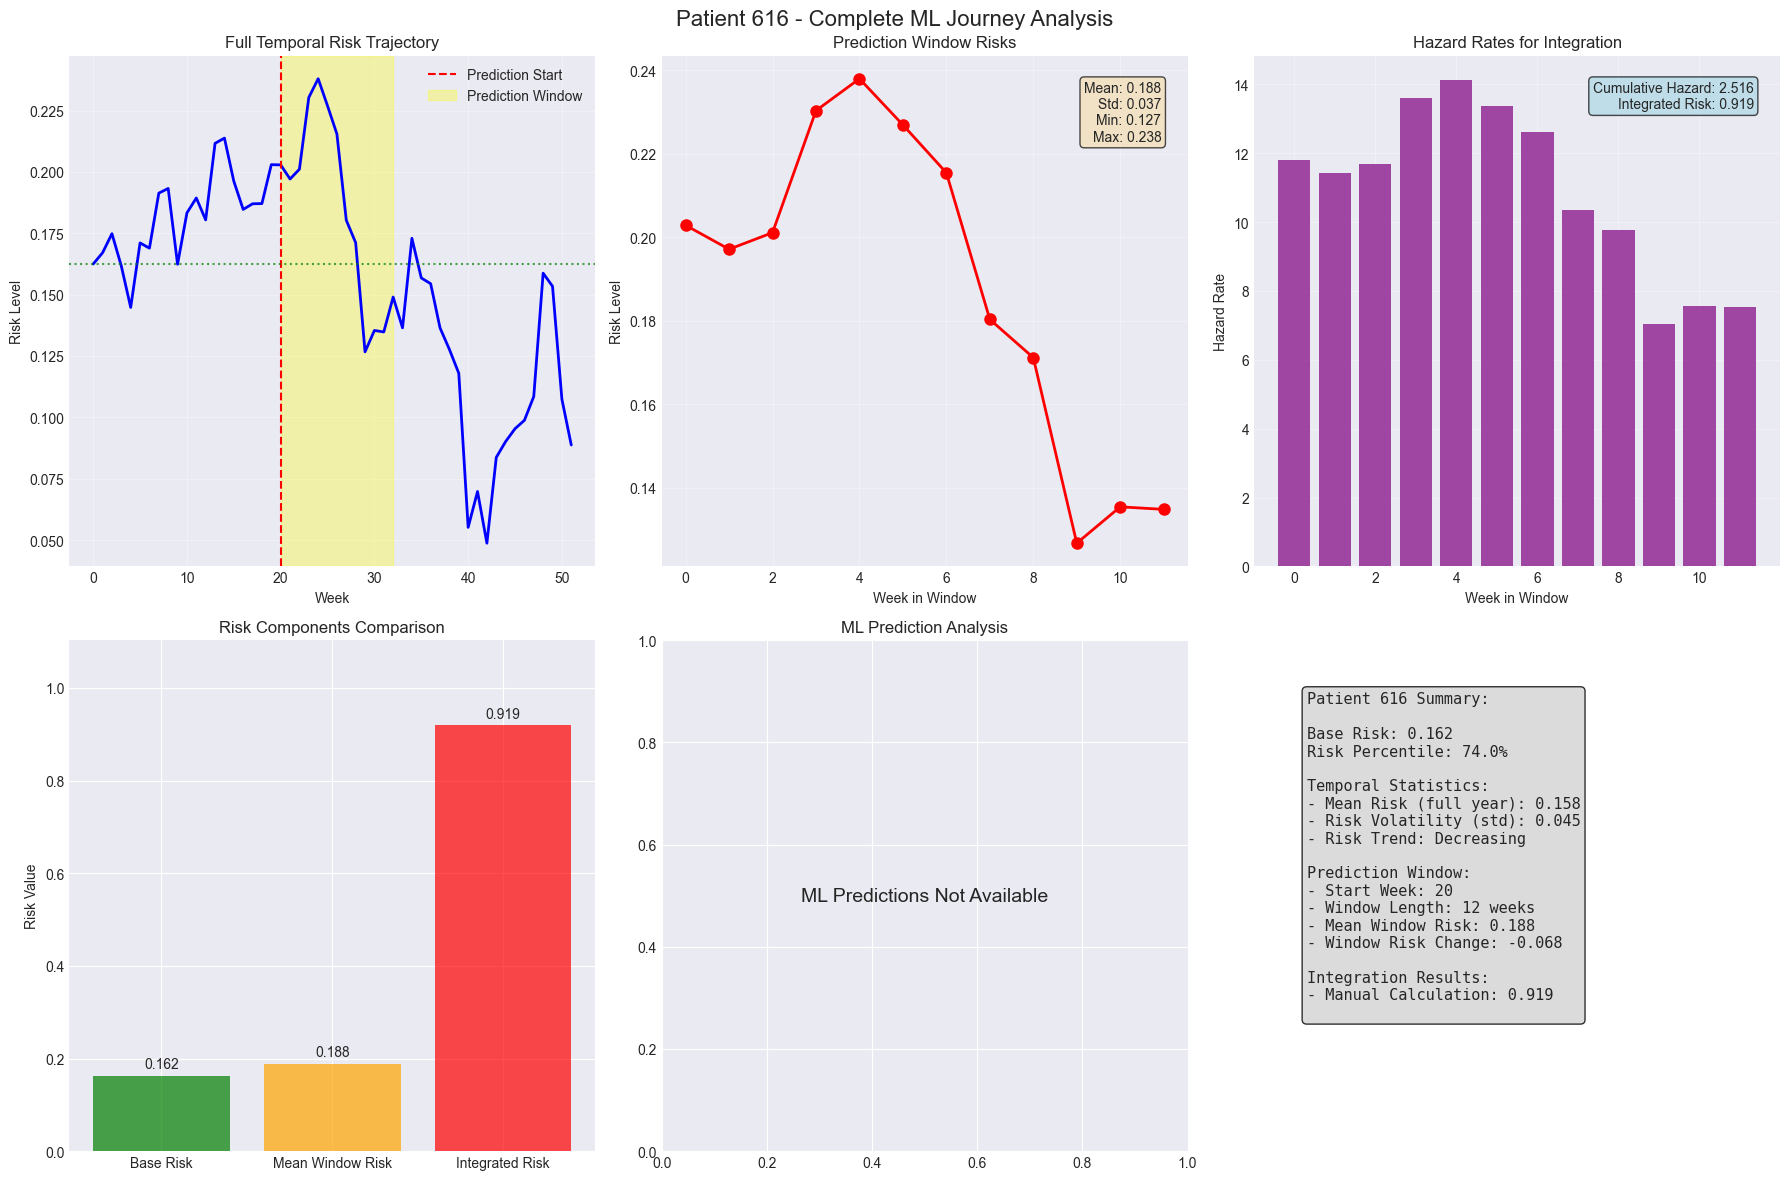


Analyzing Patient 554


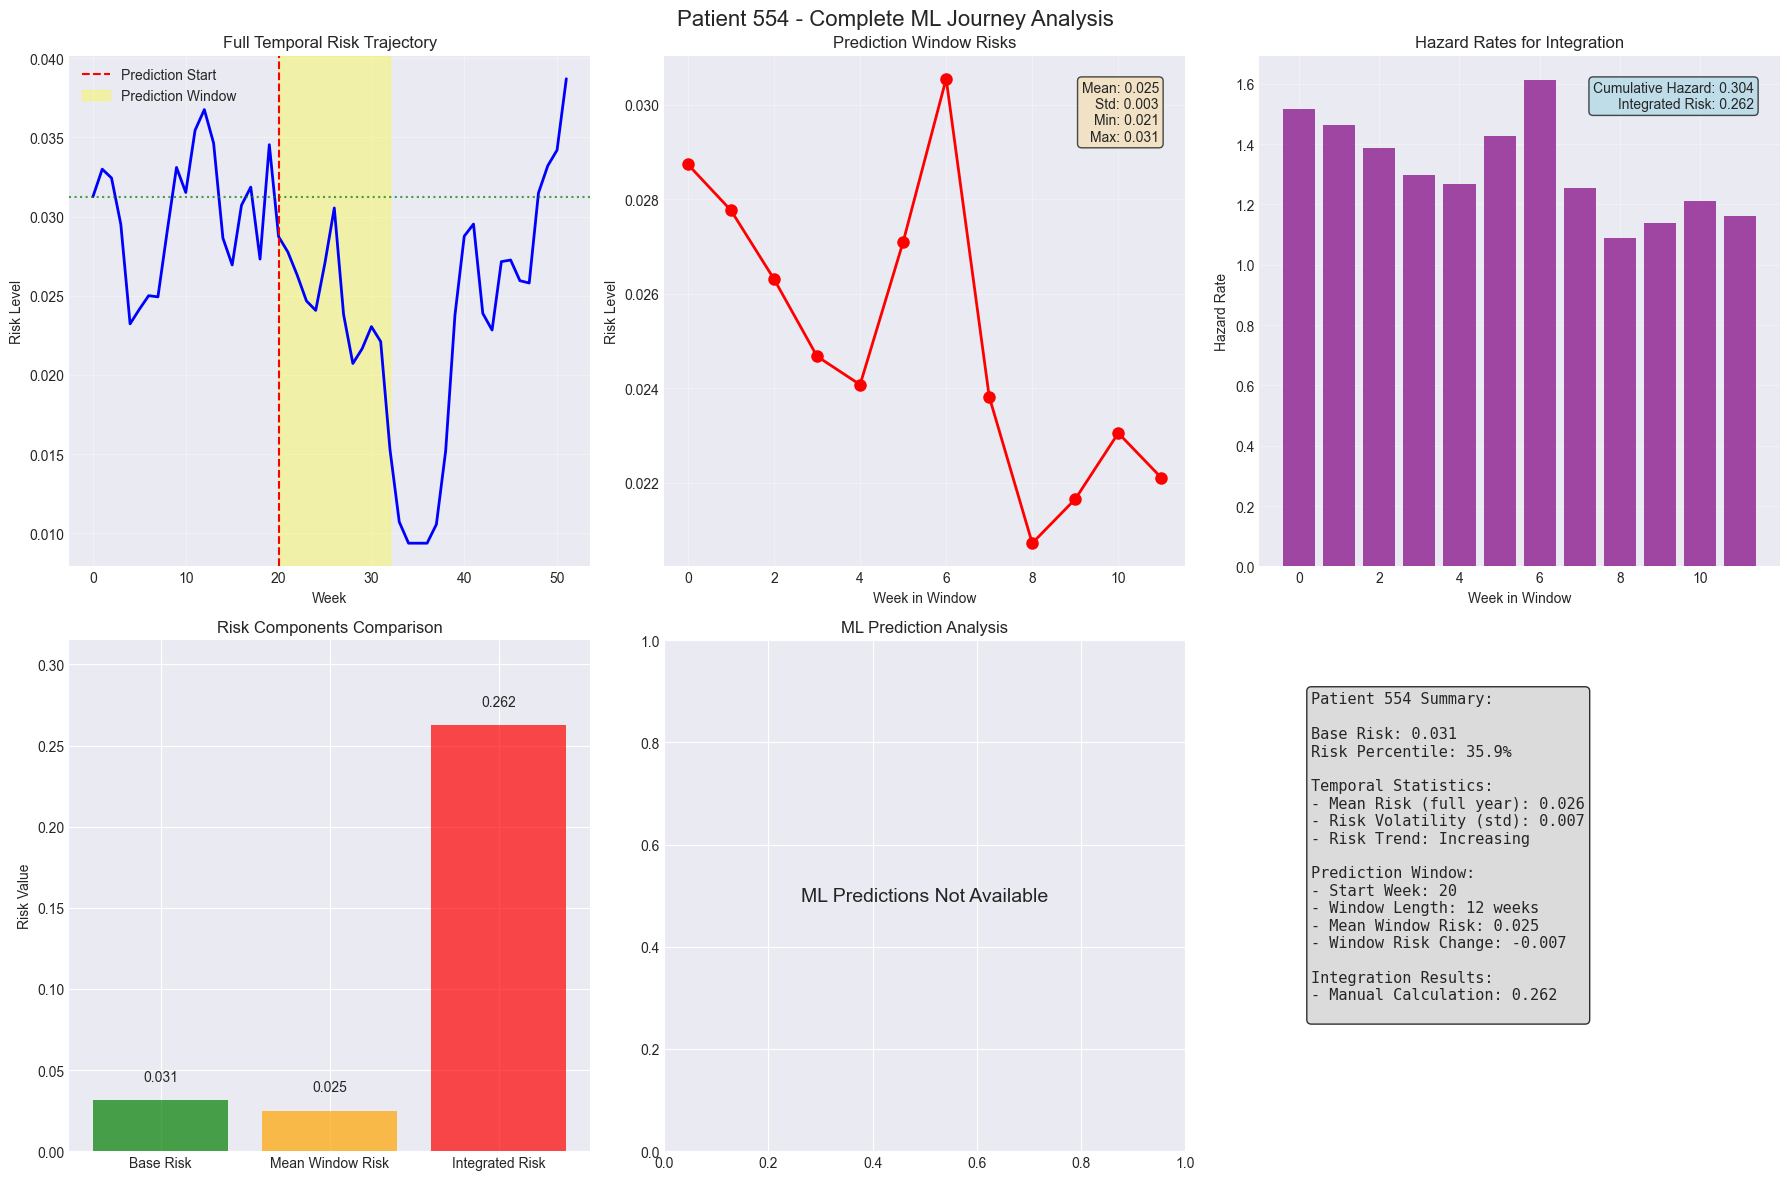


Analyzing Patient 978


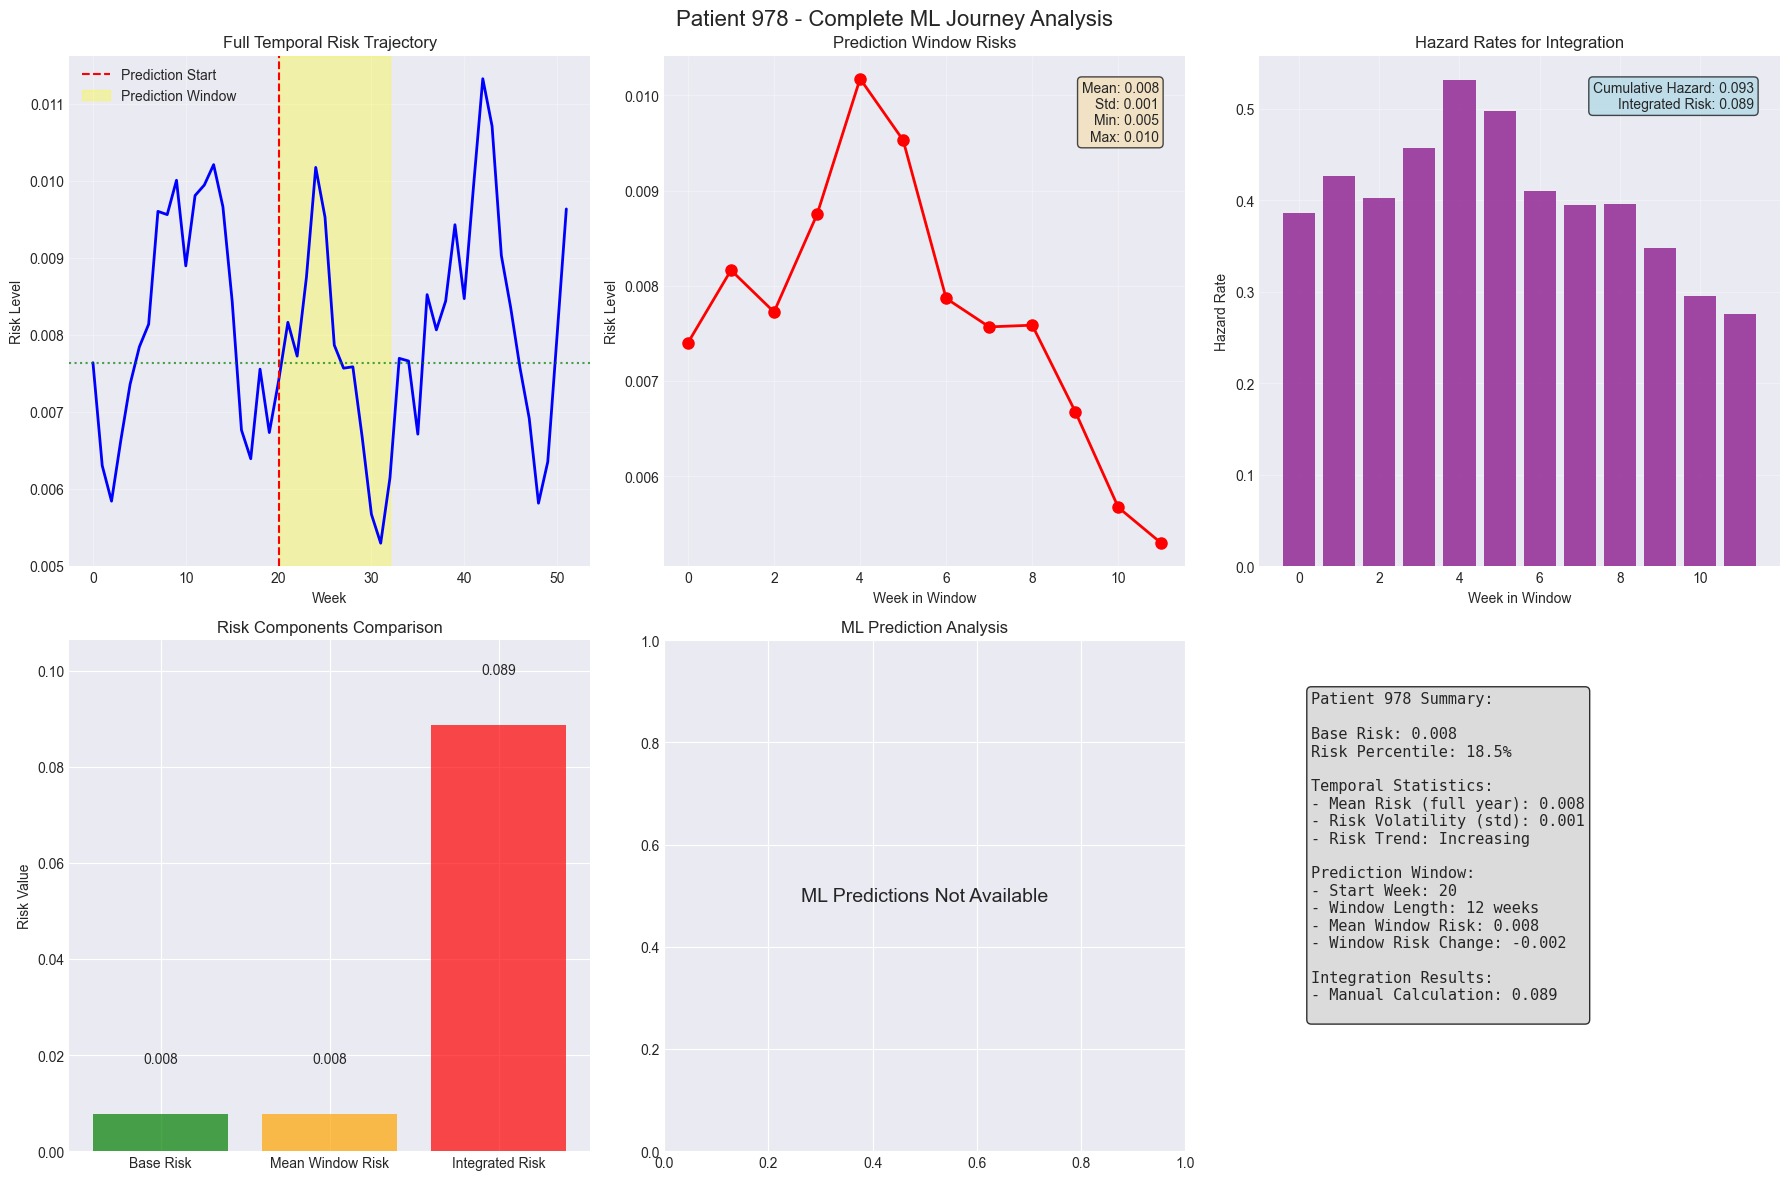

In [3]:
def analyze_patient_journey(patient_id, temporal_matrix, prediction_start, window_length, 
                          ml_predictions=None, binary_predictions=None, integrated_risks=None):
    """
    Analyze a single patient's journey through the ML prediction pipeline.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Patient {patient_id} - Complete ML Journey Analysis', fontsize=16)
    
    # 1. Full temporal risk trajectory
    ax = axes[0, 0]
    ax.plot(temporal_matrix[patient_id, :], 'b-', linewidth=2)
    ax.axvline(prediction_start, color='r', linestyle='--', label='Prediction Start')
    ax.axvspan(prediction_start, prediction_start + window_length, alpha=0.3, color='yellow', 
               label='Prediction Window')
    ax.set_xlabel('Week')
    ax.set_ylabel('Risk Level')
    ax.set_title('Full Temporal Risk Trajectory')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add base risk line
    base_risk = base_risks[patient_id]
    ax.axhline(base_risk, color='green', linestyle=':', alpha=0.7, label=f'Base Risk: {base_risk:.3f}')
    
    # 2. Prediction window detail
    ax = axes[0, 1]
    window_risks = temporal_matrix[patient_id, prediction_start:prediction_start + window_length]
    weeks = range(window_length)
    ax.plot(weeks, window_risks, 'ro-', linewidth=2, markersize=8)
    ax.set_xlabel('Week in Window')
    ax.set_ylabel('Risk Level')
    ax.set_title('Prediction Window Risks')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.95, 0.95, f'Mean: {np.mean(window_risks):.3f}\nStd: {np.std(window_risks):.3f}\n'
           f'Min: {np.min(window_risks):.3f}\nMax: {np.max(window_risks):.3f}',
           transform=ax.transAxes, ha='right', va='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # 3. Risk integration calculation
    ax = axes[0, 2]
    
    # Manual integration calculation for transparency
    timestep_duration = 1/52
    clipped_risks = np.clip(window_risks, 1e-10, 1 - 1e-10)
    timestep_hazards = -np.log(1 - clipped_risks) / timestep_duration
    cumulative_hazard = np.sum(timestep_hazards) * timestep_duration
    integrated_risk_manual = 1 - np.exp(-cumulative_hazard)
    
    # Bar plot of hazards
    ax.bar(weeks, timestep_hazards, alpha=0.7, color='purple')
    ax.set_xlabel('Week in Window')
    ax.set_ylabel('Hazard Rate')
    ax.set_title('Hazard Rates for Integration')
    ax.grid(True, alpha=0.3)
    
    # Add integration result
    ax.text(0.95, 0.95, f'Cumulative Hazard: {cumulative_hazard:.3f}\n'
           f'Integrated Risk: {integrated_risk_manual:.3f}',
           transform=ax.transAxes, ha='right', va='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # 4. Risk components breakdown
    ax = axes[1, 0]
    components = ['Base Risk', 'Mean Window Risk', 'Integrated Risk']
    values = [base_risk, np.mean(window_risks), integrated_risk_manual]
    colors = ['green', 'orange', 'red']
    bars = ax.bar(components, values, color=colors, alpha=0.7)
    ax.set_ylabel('Risk Value')
    ax.set_title('Risk Components Comparison')
    ax.set_ylim(0, max(values) * 1.2)
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
               f'{val:.3f}', ha='center', va='bottom')
    
    # 5. ML prediction details (if available)
    ax = axes[1, 1]
    if ml_predictions is not None and integrated_risks is not None:
        ml_pred = ml_predictions[patient_id]
        integrated_risk_provided = integrated_risks[patient_id]
        binary_pred = binary_predictions[patient_id] if binary_predictions is not None else None
        
        # Show prediction vs integrated risk
        pred_data = ['Integrated Risk\n(Provided)', 'ML Prediction', 'Binary Prediction']
        pred_values = [integrated_risk_provided, ml_pred, binary_pred if binary_pred is not None else 0]
        pred_colors = ['blue', 'red', 'darkred']
        
        bars = ax.bar(pred_data[:len([v for v in pred_values if v is not None])], 
                      [v for v in pred_values if v is not None], 
                      color=pred_colors[:len([v for v in pred_values if v is not None])], 
                      alpha=0.7)
        ax.set_ylabel('Prediction Value')
        ax.set_title('ML Prediction Analysis')
        ax.set_ylim(0, 1.2)
        
        # Add value labels
        for bar, val in zip(bars, [v for v in pred_values if v is not None]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}' if isinstance(val, float) else str(val), 
                   ha='center', va='bottom')
    else:
        ax.text(0.5, 0.5, 'ML Predictions Not Available', 
               transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title('ML Prediction Analysis')
    
    # 6. Summary statistics
    ax = axes[1, 2]
    ax.axis('off')
    
    summary_text = f"""Patient {patient_id} Summary:
    
Base Risk: {base_risk:.3f}
Risk Percentile: {stats.percentileofscore(base_risks, base_risk):.1f}%

Temporal Statistics:
- Mean Risk (full year): {np.mean(temporal_matrix[patient_id, :]):.3f}
- Risk Volatility (std): {np.std(temporal_matrix[patient_id, :]):.3f}
- Risk Trend: {'Increasing' if temporal_matrix[patient_id, -1] > temporal_matrix[patient_id, 0] else 'Decreasing'}

Prediction Window:
- Start Week: {prediction_start}
- Window Length: {window_length} weeks
- Mean Window Risk: {np.mean(window_risks):.3f}
- Window Risk Change: {window_risks[-1] - window_risks[0]:+.3f}

Integration Results:
- Manual Calculation: {integrated_risk_manual:.3f}
"""
    
    if ml_predictions is not None:
        summary_text += f"""- Provided Integration: {integrated_risks[patient_id]:.3f}
- ML Prediction: {ml_predictions[patient_id]:.3f}
- Binary Prediction: {binary_predictions[patient_id] if binary_predictions is not None else 'N/A'}
"""
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
           fontsize=11, va='top', family='monospace',
           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'patient_id': patient_id,
        'base_risk': base_risk,
        'window_risks': window_risks,
        'integrated_risk_manual': integrated_risk_manual,
        'integrated_risk_provided': integrated_risks[patient_id] if integrated_risks is not None else None,
        'ml_prediction': ml_predictions[patient_id] if ml_predictions is not None else None
    }

# Analyze a few random patients
print("Analyzing random patients without ML predictions first...")
random_patients = np.random.choice(n_patients, 3, replace=False)

patient_analyses = []
for patient_id in random_patients:
    print(f"\n{'='*60}")
    print(f"Analyzing Patient {patient_id}")
    print(f"{'='*60}")
    analysis = analyze_patient_journey(patient_id, temporal_matrix, prediction_start, window_length)
    patient_analyses.append(analysis)

In [4]:
#mike = analyze_patient_journey(616, temporal_matrix, prediction_start, window_length)

In [5]:
len(base_risks)
window_risks = temporal_matrix[patient_id, prediction_start:prediction_start + window_length]
window_risks

array([0.00740061, 0.00816384, 0.00772447, 0.00875005, 0.01017577,
       0.00952978, 0.00786729, 0.00756784, 0.00758569, 0.00667729,
       0.0056706 , 0.00529468])

In [6]:
random_patients

array([616, 554, 978])

12-Week Forward Stroke Risk Analysis

Mean weekly risk: 0.8087%
Mean 12-week risk: 9.4025%
Min 12-week risk: 8.2201% (Week 26)
Max 12-week risk: 10.4158% (Week 4)

Average risk multiplier (12-week/weekly): 12.14x


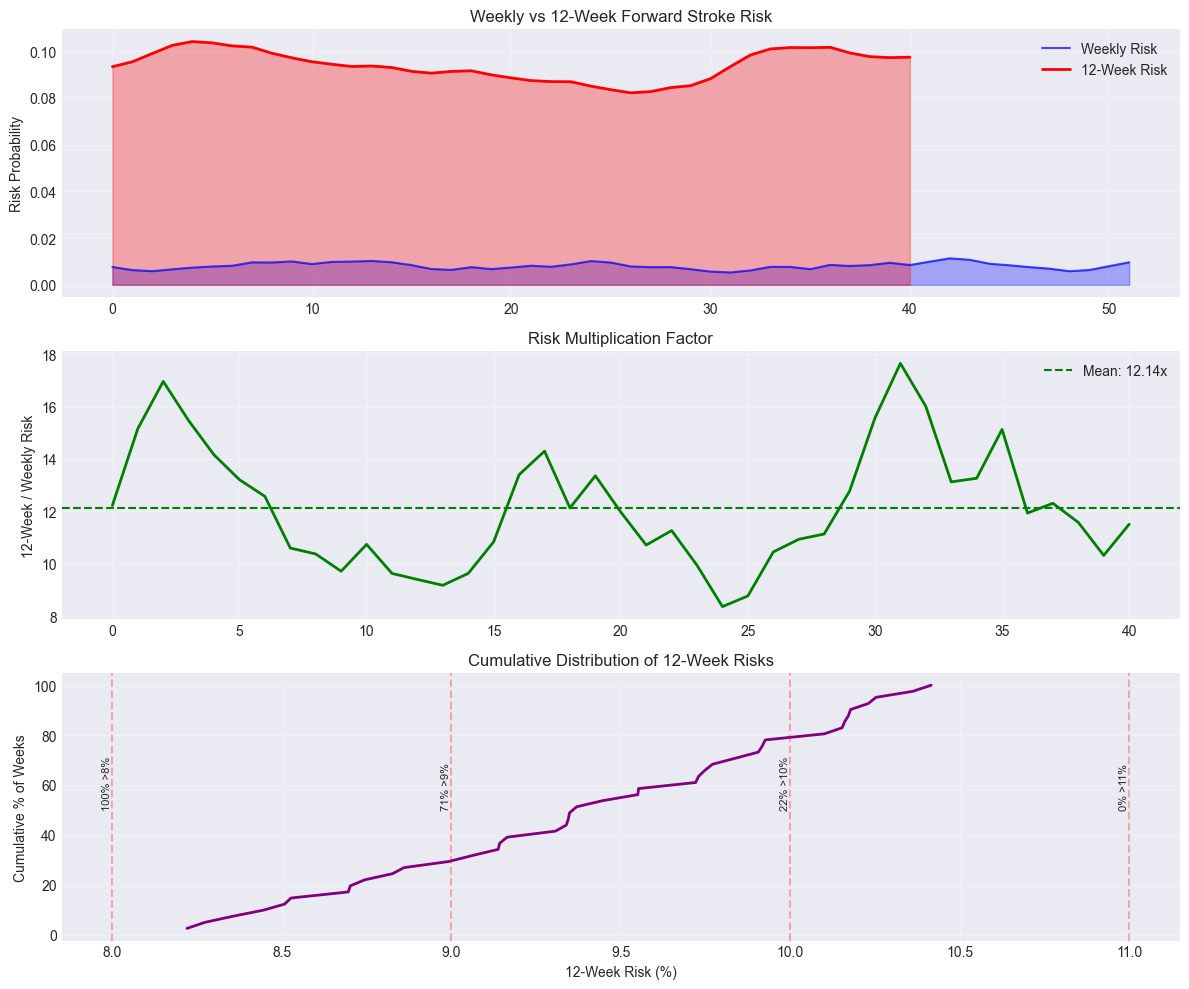


Detailed Results (First 10 weeks):
 Week  Weekly_Risk  12_Week_Risk  Risk_Multiplier
    0       0.0076        0.0934          12.2262
    1       0.0063        0.0955          15.1555
    2       0.0058        0.0991          16.9610
    3       0.0066        0.1025          15.4646
    4       0.0074        0.1042          14.1547
    5       0.0078        0.1036          13.2084
    6       0.0081        0.1023          12.5706
    7       0.0096        0.1018          10.5969
    8       0.0096        0.0992          10.3712
    9       0.0100        0.0972           9.7124

9 weeks (22.0%) have >10% 12-week risk

Week 4 (12-week risk: 10.42%):
  NNT with 30% RRR: 32

Week 26 (12-week risk: 8.22%):
  NNT with 30% RRR: 41


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

patient_id = 978

# Your weekly stroke risk data
weekly_risks = temporal_matrix[patient_id]

def calculate_12_week_risk(weekly_risks, start_week):
    """
    Calculate the 12-week forward-looking risk starting from a given week.
    
    Parameters:
    -----------
    weekly_risks : array-like
        Weekly risk probabilities
    start_week : int
        Starting week (0-indexed)
    
    Returns:
    --------
    float : 12-week cumulative risk
    """
    # Handle edge cases where we don't have 12 weeks of data
    end_week = min(start_week + 12, len(weekly_risks))
    
    # Calculate probability of NO event in each week
    no_event_probs = 1 - weekly_risks[start_week:end_week]
    
    # Probability of NO event over entire period
    no_event_12_weeks = np.prod(no_event_probs)
    
    # Probability of event occurring within 12 weeks
    event_12_weeks = 1 - no_event_12_weeks
    
    return event_12_weeks

# Calculate 12-week risk for each possible starting week
twelve_week_risks = []
valid_weeks = len(weekly_risks) - 11  # Can only calculate full 12-week risk up to week 41

for week in range(valid_weeks):
    risk = calculate_12_week_risk(weekly_risks, week)
    twelve_week_risks.append(risk)

# Create a comprehensive results dataframe
results_df = pd.DataFrame({
    'Week': range(valid_weeks),
    'Weekly_Risk': weekly_risks[:valid_weeks],
    '12_Week_Risk': twelve_week_risks,
    'Risk_Multiplier': np.array(twelve_week_risks) / weekly_risks[:valid_weeks]
})

# Print summary statistics
print("12-Week Forward Stroke Risk Analysis")
print("=" * 50)
print(f"\nMean weekly risk: {weekly_risks.mean():.4%}")
print(f"Mean 12-week risk: {np.mean(twelve_week_risks):.4%}")
print(f"Min 12-week risk: {np.min(twelve_week_risks):.4%} (Week {np.argmin(twelve_week_risks)})")
print(f"Max 12-week risk: {np.max(twelve_week_risks):.4%} (Week {np.argmax(twelve_week_risks)})")
print(f"\nAverage risk multiplier (12-week/weekly): {results_df['Risk_Multiplier'].mean():.2f}x")

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Weekly vs 12-week risks
ax1.plot(range(len(weekly_risks)), weekly_risks, 'b-', label='Weekly Risk', alpha=0.7)
ax1.plot(range(valid_weeks), twelve_week_risks, 'r-', label='12-Week Risk', linewidth=2)
ax1.fill_between(range(len(weekly_risks)), 0, weekly_risks, alpha=0.3, color='blue')
ax1.fill_between(range(valid_weeks), 0, twelve_week_risks, alpha=0.3, color='red')
ax1.set_ylabel('Risk Probability')
ax1.set_title('Weekly vs 12-Week Forward Stroke Risk')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Risk multiplier over time
ax2.plot(range(valid_weeks), results_df['Risk_Multiplier'], 'g-', linewidth=2)
ax2.axhline(y=results_df['Risk_Multiplier'].mean(), color='g', linestyle='--', 
            label=f"Mean: {results_df['Risk_Multiplier'].mean():.2f}x")
ax2.set_ylabel('12-Week / Weekly Risk')
ax2.set_title('Risk Multiplication Factor')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative distribution of 12-week risks
sorted_risks = np.sort(twelve_week_risks)
cumulative = np.arange(1, len(sorted_risks) + 1) / len(sorted_risks)
ax3.plot(sorted_risks * 100, cumulative * 100, 'purple', linewidth=2)
ax3.set_xlabel('12-Week Risk (%)')
ax3.set_ylabel('Cumulative % of Weeks')
ax3.set_title('Cumulative Distribution of 12-Week Risks')
ax3.grid(True, alpha=0.3)

# Add risk threshold lines
for threshold in [8, 9, 10, 11]:
    ax3.axvline(x=threshold, color='red', alpha=0.3, linestyle='--')
    pct_above = (np.array(twelve_week_risks) > threshold/100).mean() * 100
    ax3.text(threshold, 50, f'{pct_above:.0f}% >{threshold}%', 
             rotation=90, va='bottom', ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# Show first 10 weeks of detailed results
print("\nDetailed Results (First 10 weeks):")
print(results_df.head(10).to_string(index=False, float_format='%.4f'))

# Clinical actionability analysis
high_risk_threshold = 0.10  # 10% 12-week risk
high_risk_weeks = results_df[results_df['12_Week_Risk'] > high_risk_threshold]
print(f"\n{len(high_risk_weeks)} weeks ({len(high_risk_weeks)/valid_weeks*100:.1f}%) have >10% 12-week risk")

# Calculate NNT assuming a 30% risk reduction intervention
risk_reduction = 0.30
for week in [np.argmax(twelve_week_risks), np.argmin(twelve_week_risks)]:
    baseline_risk = twelve_week_risks[week]
    risk_with_intervention = baseline_risk * (1 - risk_reduction)
    absolute_risk_reduction = baseline_risk - risk_with_intervention
    nnt = 1 / absolute_risk_reduction
    print(f"\nWeek {week} (12-week risk: {baseline_risk:.2%}):")
    print(f"  NNT with 30% RRR: {nnt:.0f}")

## 3. Risk Integration Validation

Let's validate the risk integration process step by step and compare different approaches.

Extracting risk windows for all patients...
Applying survival-based integration...

Validating integration results...
Integration bounds validation: ✅ PASSED
Integrated risks range: [0.000, 1.000]
Mean integrated risk: 0.504
Std integrated risk: 0.357

Comparison with simple averaging:
Mean window risks range: [0.000, 0.946]
Correlation between methods: 0.786


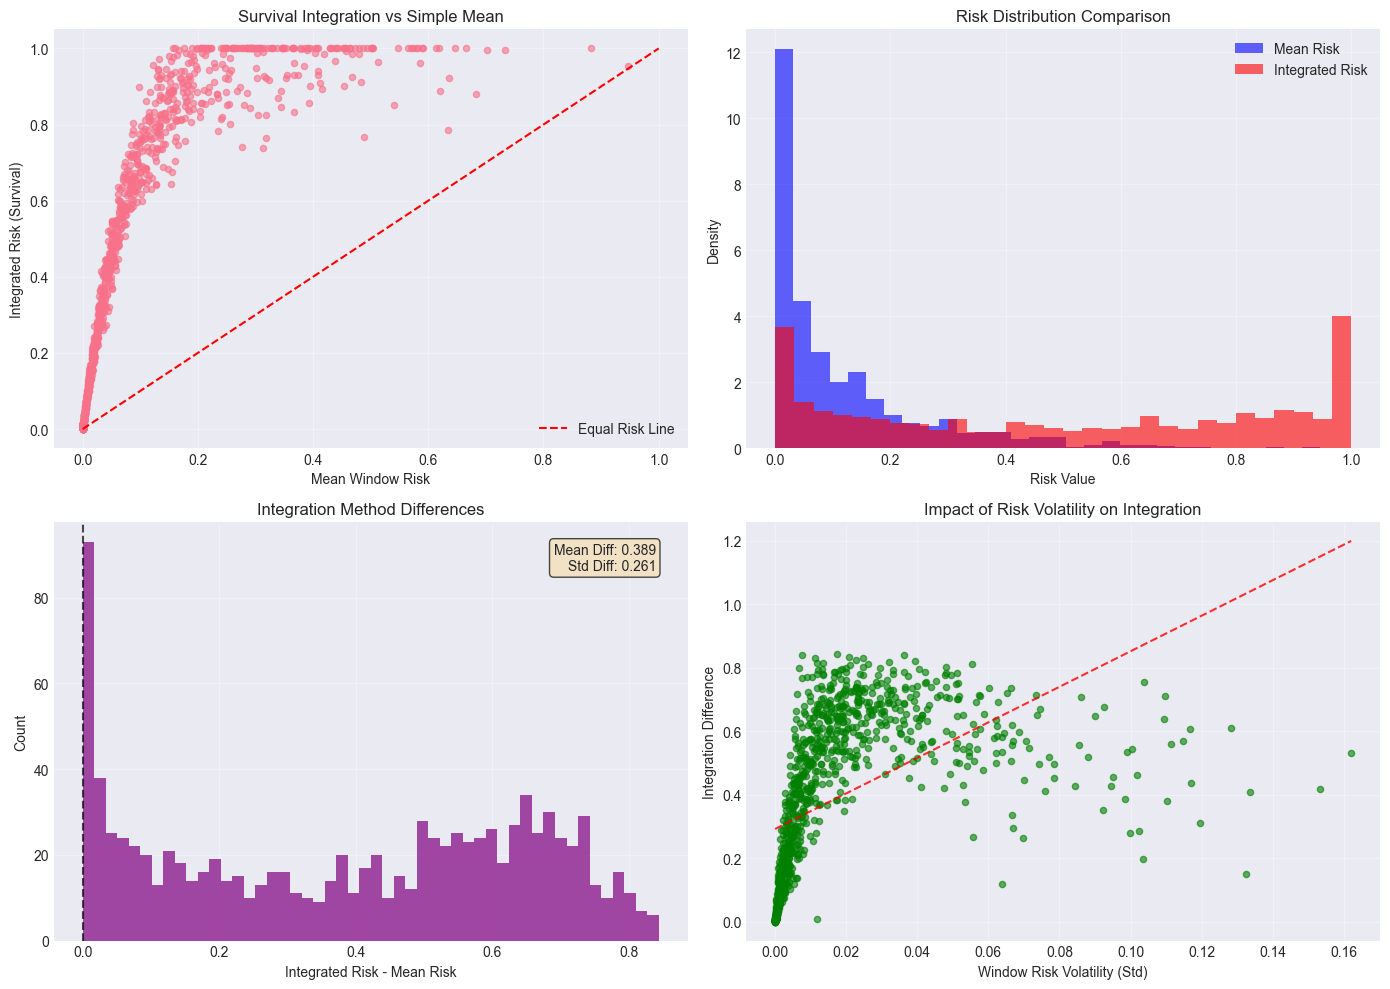


📊 Key Integration Insights:
- Survival integration generally increases risk estimates
- Effect is stronger for patients with volatile risks
- Integration preserves risk ordering (correlation = 0.786)


In [8]:
# Extract risk windows for all patients
print("Extracting risk windows for all patients...")
risk_windows = extract_risk_windows(
    temporal_matrix,
    prediction_start,
    window_length
)

# Apply survival-based integration
print("Applying survival-based integration...")
integrated_risks = integrate_window_risk(
    risk_windows,
    timestep_duration=1/52
)

# Validate integration
print("\nValidating integration results...")
is_valid = validate_integration_bounds(integrated_risks)
print(f"Integration bounds validation: {'✅ PASSED' if is_valid else '❌ FAILED'}")
print(f"Integrated risks range: [{np.min(integrated_risks):.3f}, {np.max(integrated_risks):.3f}]")
print(f"Mean integrated risk: {np.mean(integrated_risks):.3f}")
print(f"Std integrated risk: {np.std(integrated_risks):.3f}")

# Compare with simple averaging
mean_window_risks = np.mean(risk_windows, axis=1)
print(f"\nComparison with simple averaging:")
print(f"Mean window risks range: [{np.min(mean_window_risks):.3f}, {np.max(mean_window_risks):.3f}]")
print(f"Correlation between methods: {np.corrcoef(integrated_risks, mean_window_risks)[0, 1]:.3f}")

# Visualize integration validation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Integration vs Mean comparison
ax = axes[0, 0]
ax.scatter(mean_window_risks, integrated_risks, alpha=0.6, s=20)
ax.plot([0, 1], [0, 1], 'r--', label='Equal Risk Line')
ax.set_xlabel('Mean Window Risk')
ax.set_ylabel('Integrated Risk (Survival)')
ax.set_title('Survival Integration vs Simple Mean')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Distribution comparison
ax = axes[0, 1]
ax.hist(mean_window_risks, bins=30, alpha=0.6, density=True, label='Mean Risk', color='blue')
ax.hist(integrated_risks, bins=30, alpha=0.6, density=True, label='Integrated Risk', color='red')
ax.set_xlabel('Risk Value')
ax.set_ylabel('Density')
ax.set_title('Risk Distribution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Integration difference analysis
ax = axes[1, 0]
differences = integrated_risks - mean_window_risks
ax.hist(differences, bins=50, alpha=0.7, color='purple')
ax.set_xlabel('Integrated Risk - Mean Risk')
ax.set_ylabel('Count')
ax.set_title('Integration Method Differences')
ax.axvline(0, color='black', linestyle='--', alpha=0.7)
ax.grid(True, alpha=0.3)

# Add statistics
ax.text(0.95, 0.95, f'Mean Diff: {np.mean(differences):.3f}\nStd Diff: {np.std(differences):.3f}',
       transform=ax.transAxes, ha='right', va='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# 4. Risk volatility impact
ax = axes[1, 1]
window_volatility = np.std(risk_windows, axis=1)
ax.scatter(window_volatility, differences, alpha=0.6, s=20, color='green')
ax.set_xlabel('Window Risk Volatility (Std)')
ax.set_ylabel('Integration Difference')
ax.set_title('Impact of Risk Volatility on Integration')
ax.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(window_volatility, differences, 1)
p = np.poly1d(z)
ax.plot(np.sort(window_volatility), p(np.sort(window_volatility)), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Integration Insights:")
print(f"- Survival integration generally {'increases' if np.mean(differences) > 0 else 'decreases'} risk estimates")
print(f"- Effect is {'stronger' if abs(z[0]) > 0.1 else 'weaker'} for patients with volatile risks")
print(f"- Integration preserves risk ordering (correlation = {np.corrcoef(integrated_risks, mean_window_risks)[0, 1]:.3f})")

In [9]:
risk_windows[patient_id]

array([0.00740061, 0.00816384, 0.00772447, 0.00875005, 0.01017577,
       0.00952978, 0.00786729, 0.00756784, 0.00758569, 0.00667729,
       0.0056706 , 0.00529468])

In [10]:
integrated_risks[patient_id]

np.float64(0.08674831334086802)

In [17]:
# Calibration check
def validate_calibration(integrated_risks, observed_outcomes, n_bins=10):
    """Check if integrated risks match observed event rates"""
    bins = np.percentile(integrated_risks, np.linspace(0, 100, n_bins+1))
    calibration_data = []
    
    for i in range(n_bins):
        mask = (integrated_risks >= bins[i]) & (integrated_risks < bins[i+1])
        if mask.sum() > 0:
            predicted = integrated_risks[mask].mean()
            observed = observed_outcomes[mask].mean()
            calibration_data.append({
                'bin': i,
                'predicted': predicted,
                'observed': observed,
                'count': mask.sum()
            })
    
    return pd.DataFrame(calibration_data)

# Temporal consistency check  
def check_temporal_consistency(risk_windows, integrated_risks):
    """Ensure longer windows → higher integrated risk"""
    results = []
    for window_size in [4, 8, 12, 16]:  # Different window lengths
        truncated_windows = risk_windows[:, :window_size]
        truncated_integrated = integrate_window_risk(
            truncated_windows, 
            timestep_duration=1/52
        )
        results.append({
            'window_size': window_size,
            'mean_integrated_risk': truncated_integrated.mean()
        })
    return pd.DataFrame(results)

## 4. ML Prediction Generation Analysis

Now let's generate ML predictions and analyze exactly how they're created.

In [18]:
label_probabilities

array([3.53884312e-01, 3.44663032e-02, 8.85914203e-01, 1.03577355e-01,
       7.04275399e-01, 2.34693967e-01, 1.61269263e-01, 9.18224290e-02,
       1.00000000e+00, 8.88677766e-01, 4.81342684e-01, 1.00000000e+00,
       6.47003016e-01, 1.95187902e-01, 2.05629529e-01, 1.00000000e+00,
       9.76727891e-01, 4.32226255e-01, 1.82755859e-01, 7.71989958e-01,
       9.96602513e-01, 2.29099529e-02, 3.25555133e-01, 8.35038695e-01,
       8.47539735e-02, 1.14795541e-01, 1.00000000e+00, 5.27087894e-01,
       3.57133988e-04, 4.62000286e-01, 5.64629261e-01, 1.90516259e-01,
       9.21866798e-01, 3.13475257e-01, 6.31518317e-01, 1.00000000e+00,
       5.61183762e-02, 6.97015748e-01, 8.86769664e-01, 3.70876565e-01,
       2.36931543e-01, 7.87998787e-01, 2.14471388e-02, 2.69619572e-01,
       1.00000000e+00, 1.00000000e+00, 1.37866715e-02, 1.49821167e-01,
       2.24930966e-01, 2.15248921e-01, 1.00000000e+00, 5.85932127e-01,
       6.82850734e-01, 8.85322994e-01, 1.00000000e+00, 6.25386728e-01,
      

In [28]:
event_times

array([-1, -1, -1, -1, -1, -1, -1, -1,  5, 30, -1, -1, -1, -1, -1, 23, -1,
       -1, -1, -1, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, 10, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 45, -1,
       -1, -1, -1, 46, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, 18, -1, -1, -1, -1, 40, 43, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1, -1,
       -1, -1, 35, -1, -1, -1, -1, -1, 28, -1, -1, 19, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, 40, -1, -1, -1, -1, -1, -1, -1,  6, -1,
       -1, -1, -1, -1, -1, -1, -1, 43,  8, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1, -1, -1, 24, -1, -1,
       15, -1, -1, -1, -1, -1, 23, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  4, -1, -1, -1

Generating ML predictions with detailed tracking...
Generating labels using temporal event generation...
Generated 23 positive labels (2.3% prevalence)
Expected prevalence (theoretical): 2.8%
\nEvent Generation Analysis:
Total patients with events: 113 (11.3%)
Target annual rate: 12.0%
\nOptimizing noise parameters...
Optimal correlation: 0.950
Optimal scale: 0.278
\nOptimal threshold: 0.713
\nAchieved Performance:
Sensitivity: 78.3%
PPV: 5.6%
Specificity: 69.2%
F1 Score: 0.105


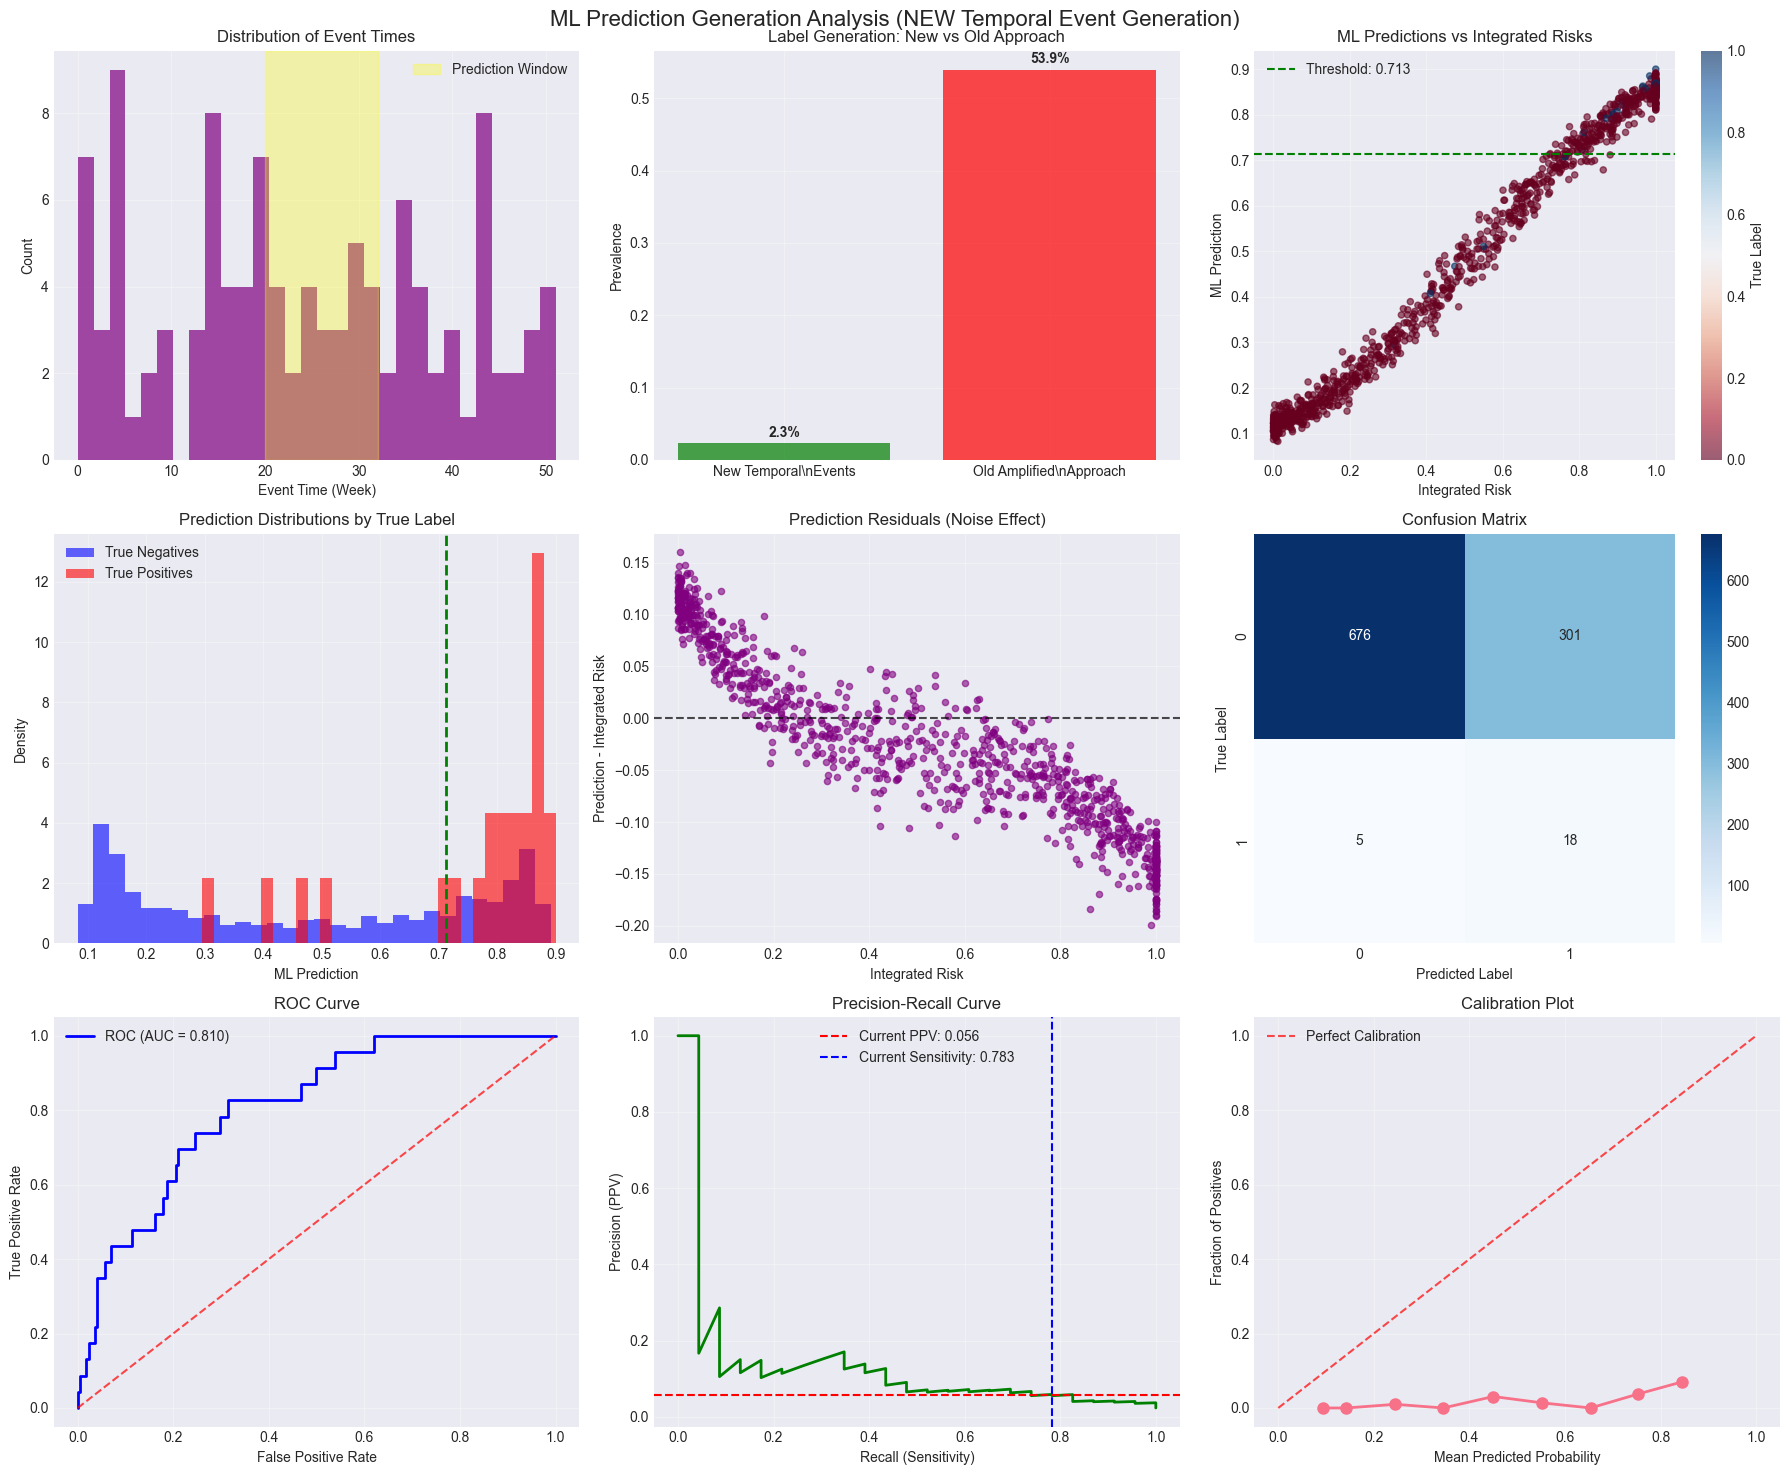

\n📊 ML Prediction Generation Insights (NEW APPROACH):
- Using temporal event generation (no artificial amplification)
- Realistic prevalence: 2.3% vs expected 2.8%
- Annual event rate: 11.3% vs target 12.0%
- Prediction correlation with integrated risk: 0.994
- Mean prediction for positives: 0.757
- Mean prediction for negatives: 0.474
- Prediction separation: 0.283


In [27]:
# Generate ML predictions with detailed tracking using NEW temporal event generation
print("Generating ML predictions with detailed tracking...")

# Import the new temporal event generation function
from pop_ml_simulator.ml_simulation import generate_temporal_events

# First, let's manually create the ML simulator to have more control
ml_simulator = MLPredictionSimulator(
    target_sensitivity=0.8,
    target_ppv=0.3,
    calibration='sigmoid',
    random_seed=42
)

# Generate ground truth labels using NEW temporal event generation approach
print("Generating labels using temporal event generation...")
event_matrix, event_times = generate_temporal_events(
    temporal_matrix,
    timestep_duration=1/52,
    random_seed=42
)

# Extract labels for the prediction window
window_end = prediction_start + window_length
true_labels = np.zeros(n_patients, dtype=int)

for i in range(n_patients):
    if event_times[i] >= 0:  # Patient has an event
        # Check if event occurs within the prediction window
        if prediction_start <= event_times[i] < window_end:
            true_labels[i] = 1

print(f"Generated {np.sum(true_labels)} positive labels ({np.mean(true_labels):.1%} prevalence)")
print(f"Expected prevalence (theoretical): {0.12 * (window_length / 52):.1%}")

# Analyze event generation
total_events = np.sum(event_times >= 0)
annual_event_rate = total_events / n_patients
print(f"\\nEvent Generation Analysis:")
print(f"Total patients with events: {total_events} ({annual_event_rate:.1%})")
print(f"Target annual rate: 12.0%")

# Optimize noise parameters
print("\\nOptimizing noise parameters...")
optimization_params = ml_simulator.optimize_noise_parameters(
    true_labels, integrated_risks, n_iterations=15
)

print(f"Optimal correlation: {optimization_params['correlation']:.3f}")
print(f"Optimal scale: {optimization_params['scale']:.3f}")

# Generate predictions with tracking
predictions, binary_predictions = ml_simulator.generate_predictions(
    true_labels,
    integrated_risks,
    optimization_params['correlation'],
    optimization_params['scale']
)

print(f"\\nOptimal threshold: {ml_simulator.threshold:.3f}")

# Evaluate performance
metrics = evaluate_threshold_based(true_labels, predictions, ml_simulator.threshold)
print(f"\\nAchieved Performance:")
print(f"Sensitivity: {metrics['sensitivity']:.1%}")
print(f"PPV: {metrics['ppv']:.1%}")
print(f"Specificity: {metrics['specificity']:.1%}")
print(f"F1 Score: {metrics['f1']:.3f}")

# Set label_probabilities for compatibility with rest of notebook
# (This is just for visualization - not used for actual label generation)
label_probabilities = integrated_risks

# Detailed prediction generation analysis
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('ML Prediction Generation Analysis (NEW Temporal Event Generation)', fontsize=16)

# 1. Event timing analysis (NEW)
ax = axes[0, 0]
# Show distribution of event times
valid_event_times = event_times[event_times >= 0]
ax.hist(valid_event_times, bins=30, alpha=0.7, color='purple')
ax.axvspan(prediction_start, prediction_start + window_length, alpha=0.3, color='yellow', 
           label='Prediction Window')
ax.set_xlabel('Event Time (Week)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Event Times')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Label generation comparison (NEW vs OLD approach)
ax = axes[0, 1]
# Show how new approach compares to old amplified approach
old_label_probs = integrated_risks * 1.2  # Old amplified approach
old_label_probs = np.clip(old_label_probs, 0.01, 0.95)
np.random.seed(42)
old_labels = np.random.binomial(1, old_label_probs)

ax.bar(['New Temporal\\nEvents', 'Old Amplified\\nApproach'], 
       [np.mean(true_labels), np.mean(old_labels)], 
       color=['green', 'red'], alpha=0.7)
ax.set_ylabel('Prevalence')
ax.set_title('Label Generation: New vs Old Approach')
ax.grid(True, alpha=0.3)

# Add prevalence values as text
for i, val in enumerate([np.mean(true_labels), np.mean(old_labels)]):
    ax.text(i, val + 0.005, f'{val:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. Predictions vs integrated risks
ax = axes[0, 2]
scatter = ax.scatter(integrated_risks, predictions, c=true_labels, 
                    cmap='RdBu', alpha=0.6, s=20)
ax.set_xlabel('Integrated Risk')
ax.set_ylabel('ML Prediction')
ax.set_title('ML Predictions vs Integrated Risks')
ax.axhline(ml_simulator.threshold, color='green', linestyle='--', 
          label=f'Threshold: {ml_simulator.threshold:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='True Label')

# 4. Prediction distribution by true label
ax = axes[1, 0]
ax.hist(predictions[true_labels == 0], bins=30, alpha=0.6, density=True, 
       label='True Negatives', color='blue')
ax.hist(predictions[true_labels == 1], bins=30, alpha=0.6, density=True, 
       label='True Positives', color='red')
ax.axvline(ml_simulator.threshold, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('ML Prediction')
ax.set_ylabel('Density')
ax.set_title('Prediction Distributions by True Label')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Noise analysis
ax = axes[1, 1]
# Reconstruct noise component
noise_correlation = optimization_params['correlation']
noise_scale = optimization_params['scale']

# This is approximate since we can't access the exact noise
prediction_residuals = predictions - integrated_risks
ax.scatter(integrated_risks, prediction_residuals, alpha=0.6, s=20, color='purple')
ax.set_xlabel('Integrated Risk')
ax.set_ylabel('Prediction - Integrated Risk')
ax.set_title('Prediction Residuals (Noise Effect)')
ax.axhline(0, color='black', linestyle='--', alpha=0.7)
ax.grid(True, alpha=0.3)

# 6. Confusion matrix visualization
ax = axes[1, 2]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# 7. ROC curve
ax = axes[2, 0]
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.7)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# 8. Precision-Recall curve
ax = axes[2, 1]
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)
ax.plot(recall, precision, 'g-', linewidth=2)
ax.axhline(metrics['ppv'], color='red', linestyle='--', 
          label=f"Current PPV: {metrics['ppv']:.3f}")
ax.axvline(metrics['sensitivity'], color='blue', linestyle='--', 
          label=f"Current Sensitivity: {metrics['sensitivity']:.3f}")
ax.set_xlabel('Recall (Sensitivity)')
ax.set_ylabel('Precision (PPV)')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# 9. Calibration plot
ax = axes[2, 2]
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    true_labels, predictions, n_bins=10, strategy='uniform'
)
ax.plot(mean_predicted_value, fraction_of_positives, 'o-', linewidth=2, markersize=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Perfect Calibration')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Calibration Plot')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📊 ML Prediction Generation Insights (NEW APPROACH):")
print(f"- Using temporal event generation (no artificial amplification)")
print(f"- Realistic prevalence: {np.mean(true_labels):.1%} vs expected {0.12 * (window_length / 52):.1%}")
print(f"- Annual event rate: {annual_event_rate:.1%} vs target 12.0%")
print(f"- Prediction correlation with integrated risk: {np.corrcoef(integrated_risks, predictions)[0, 1]:.3f}")
print(f"- Mean prediction for positives: {np.mean(predictions[true_labels == 1]):.3f}")
print(f"- Mean prediction for negatives: {np.mean(predictions[true_labels == 0]):.3f}")
print(f"- Prediction separation: {np.mean(predictions[true_labels == 1]) - np.mean(predictions[true_labels == 0]):.3f}")

## 5. Performance Metrics Deep Dive

Let's examine why the ML system achieves its current performance levels.

Analyzing performance drivers...


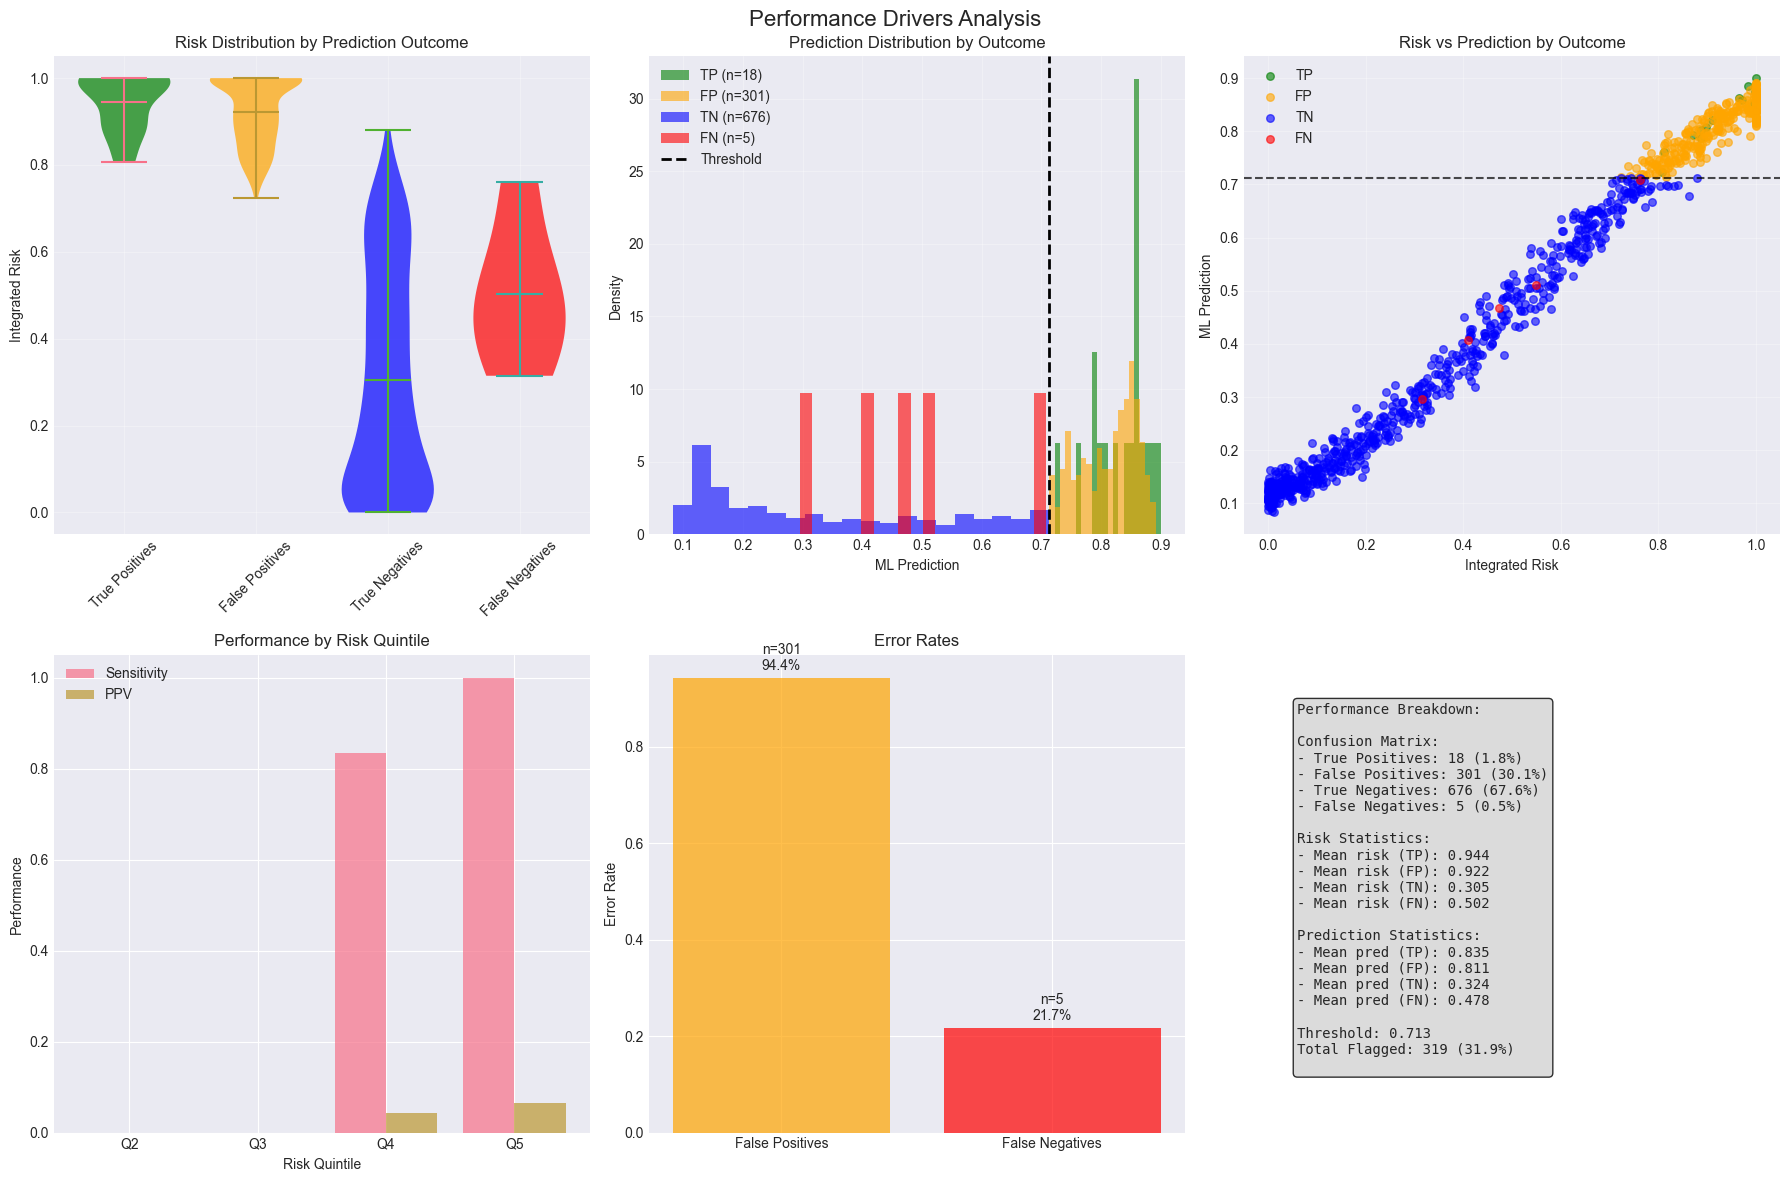

In [13]:
def analyze_performance_drivers(true_labels, predictions, integrated_risks, threshold):
    """
    Analyze what drives the ML performance metrics.
    """
    binary_preds = (predictions >= threshold).astype(int)
    
    # Identify different patient groups
    tp_mask = (true_labels == 1) & (binary_preds == 1)
    fp_mask = (true_labels == 0) & (binary_preds == 1)
    tn_mask = (true_labels == 0) & (binary_preds == 0)
    fn_mask = (true_labels == 1) & (binary_preds == 0)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Performance Drivers Analysis', fontsize=16)
    
    # 1. Risk distribution by outcome
    ax = axes[0, 0]
    groups = [
        ('True Positives', integrated_risks[tp_mask], 'green'),
        ('False Positives', integrated_risks[fp_mask], 'orange'),
        ('True Negatives', integrated_risks[tn_mask], 'blue'),
        ('False Negatives', integrated_risks[fn_mask], 'red')
    ]
    
    positions = []
    for i, (label, data, color) in enumerate(groups):
        if len(data) > 0:
            parts = ax.violinplot([data], positions=[i], widths=0.7, 
                                 showmeans=True, showextrema=True)
            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_alpha(0.7)
            positions.append(i)
    
    ax.set_xticks(positions)
    ax.set_xticklabels([g[0] for i, g in enumerate(groups) if i in positions], rotation=45)
    ax.set_ylabel('Integrated Risk')
    ax.set_title('Risk Distribution by Prediction Outcome')
    ax.grid(True, alpha=0.3)
    
    # 2. Prediction distribution by outcome
    ax = axes[0, 1]
    for i, (label, mask, color) in enumerate([
        ('TP', tp_mask, 'green'),
        ('FP', fp_mask, 'orange'),
        ('TN', tn_mask, 'blue'),
        ('FN', fn_mask, 'red')
    ]):
        if np.sum(mask) > 0:
            ax.hist(predictions[mask], bins=20, alpha=0.6, density=True, 
                   label=f'{label} (n={np.sum(mask)})', color=color)
    
    ax.axvline(threshold, color='black', linestyle='--', linewidth=2, label='Threshold')
    ax.set_xlabel('ML Prediction')
    ax.set_ylabel('Density')
    ax.set_title('Prediction Distribution by Outcome')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Risk vs prediction scatter by outcome
    ax = axes[0, 2]
    for label, mask, color in [
        ('TP', tp_mask, 'green'),
        ('FP', fp_mask, 'orange'),
        ('TN', tn_mask, 'blue'),
        ('FN', fn_mask, 'red')
    ]:
        if np.sum(mask) > 0:
            ax.scatter(integrated_risks[mask], predictions[mask], 
                      alpha=0.6, s=30, label=label, color=color)
    
    ax.axhline(threshold, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel('Integrated Risk')
    ax.set_ylabel('ML Prediction')
    ax.set_title('Risk vs Prediction by Outcome')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Performance by risk quintile
    ax = axes[1, 0]
    risk_quintiles = pd.qcut(integrated_risks, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
    quintile_metrics = []
    for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
        mask = risk_quintiles == q
        if np.sum(mask) > 0 and np.sum(true_labels[mask]) > 0:
            q_metrics = evaluate_threshold_based(
                true_labels[mask], predictions[mask], threshold
            )
            quintile_metrics.append({
                'quintile': q,
                'sensitivity': q_metrics['sensitivity'],
                'ppv': q_metrics['ppv'],
                'prevalence': np.mean(true_labels[mask])
            })
    
    if quintile_metrics:
        q_df = pd.DataFrame(quintile_metrics)
        x = range(len(q_df))
        ax.bar(x, q_df['sensitivity'], width=0.4, label='Sensitivity', alpha=0.7)
        ax.bar([i+0.4 for i in x], q_df['ppv'], width=0.4, label='PPV', alpha=0.7)
        ax.set_xticks([i+0.2 for i in x])
        ax.set_xticklabels(q_df['quintile'])
        ax.set_ylabel('Performance')
        ax.set_xlabel('Risk Quintile')
        ax.set_title('Performance by Risk Quintile')
        ax.legend()
    
    # 5. Error analysis
    ax = axes[1, 1]
    error_data = [
        ('False Positives', np.sum(fp_mask), np.sum(fp_mask) / np.sum(binary_preds == 1) if np.sum(binary_preds == 1) > 0 else 0),
        ('False Negatives', np.sum(fn_mask), np.sum(fn_mask) / np.sum(true_labels == 1) if np.sum(true_labels == 1) > 0 else 0)
    ]
    
    labels = [d[0] for d in error_data]
    counts = [d[1] for d in error_data]
    rates = [d[2] for d in error_data]
    
    x = range(len(labels))
    ax.bar(x, rates, color=['orange', 'red'], alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Error Rate')
    ax.set_title('Error Rates')
    
    # Add count labels
    for i, (count, rate) in enumerate(zip(counts, rates)):
        ax.text(i, rate + 0.01, f'n={count}\n{rate:.1%}', 
               ha='center', va='bottom')
    
    # 6. Summary statistics
    ax = axes[1, 2]
    ax.axis('off')
    
    summary_text = f"""Performance Breakdown:

Confusion Matrix:
- True Positives: {np.sum(tp_mask)} ({np.sum(tp_mask)/len(true_labels):.1%})
- False Positives: {np.sum(fp_mask)} ({np.sum(fp_mask)/len(true_labels):.1%})
- True Negatives: {np.sum(tn_mask)} ({np.sum(tn_mask)/len(true_labels):.1%})
- False Negatives: {np.sum(fn_mask)} ({np.sum(fn_mask)/len(true_labels):.1%})

Risk Statistics:
- Mean risk (TP): {np.mean(integrated_risks[tp_mask]) if np.sum(tp_mask) > 0 else 0:.3f}
- Mean risk (FP): {np.mean(integrated_risks[fp_mask]) if np.sum(fp_mask) > 0 else 0:.3f}
- Mean risk (TN): {np.mean(integrated_risks[tn_mask]) if np.sum(tn_mask) > 0 else 0:.3f}
- Mean risk (FN): {np.mean(integrated_risks[fn_mask]) if np.sum(fn_mask) > 0 else 0:.3f}

Prediction Statistics:
- Mean pred (TP): {np.mean(predictions[tp_mask]) if np.sum(tp_mask) > 0 else 0:.3f}
- Mean pred (FP): {np.mean(predictions[fp_mask]) if np.sum(fp_mask) > 0 else 0:.3f}
- Mean pred (TN): {np.mean(predictions[tn_mask]) if np.sum(tn_mask) > 0 else 0:.3f}
- Mean pred (FN): {np.mean(predictions[fn_mask]) if np.sum(fn_mask) > 0 else 0:.3f}

Threshold: {threshold:.3f}
Total Flagged: {np.sum(binary_preds)} ({np.mean(binary_preds):.1%})
"""
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
           fontsize=10, va='top', family='monospace',
           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'tp': np.sum(tp_mask),
        'fp': np.sum(fp_mask),
        'tn': np.sum(tn_mask),
        'fn': np.sum(fn_mask),
        'threshold': threshold
    }

# Analyze performance drivers
print("Analyzing performance drivers...")
perf_analysis = analyze_performance_drivers(
    true_labels, predictions, integrated_risks, ml_simulator.threshold
)

## 6. Error Pattern Analysis

Let's examine specific patients where the ML system makes errors to understand patterns.

False Positives: 301 patients
False Negatives: 5 patients

FALSE POSITIVE ANALYSIS

Analyzing False Positive Patient 939:
- Integrated Risk: 0.804
- ML Prediction: 0.731
- Label Probability: 0.804
- True Label: 0


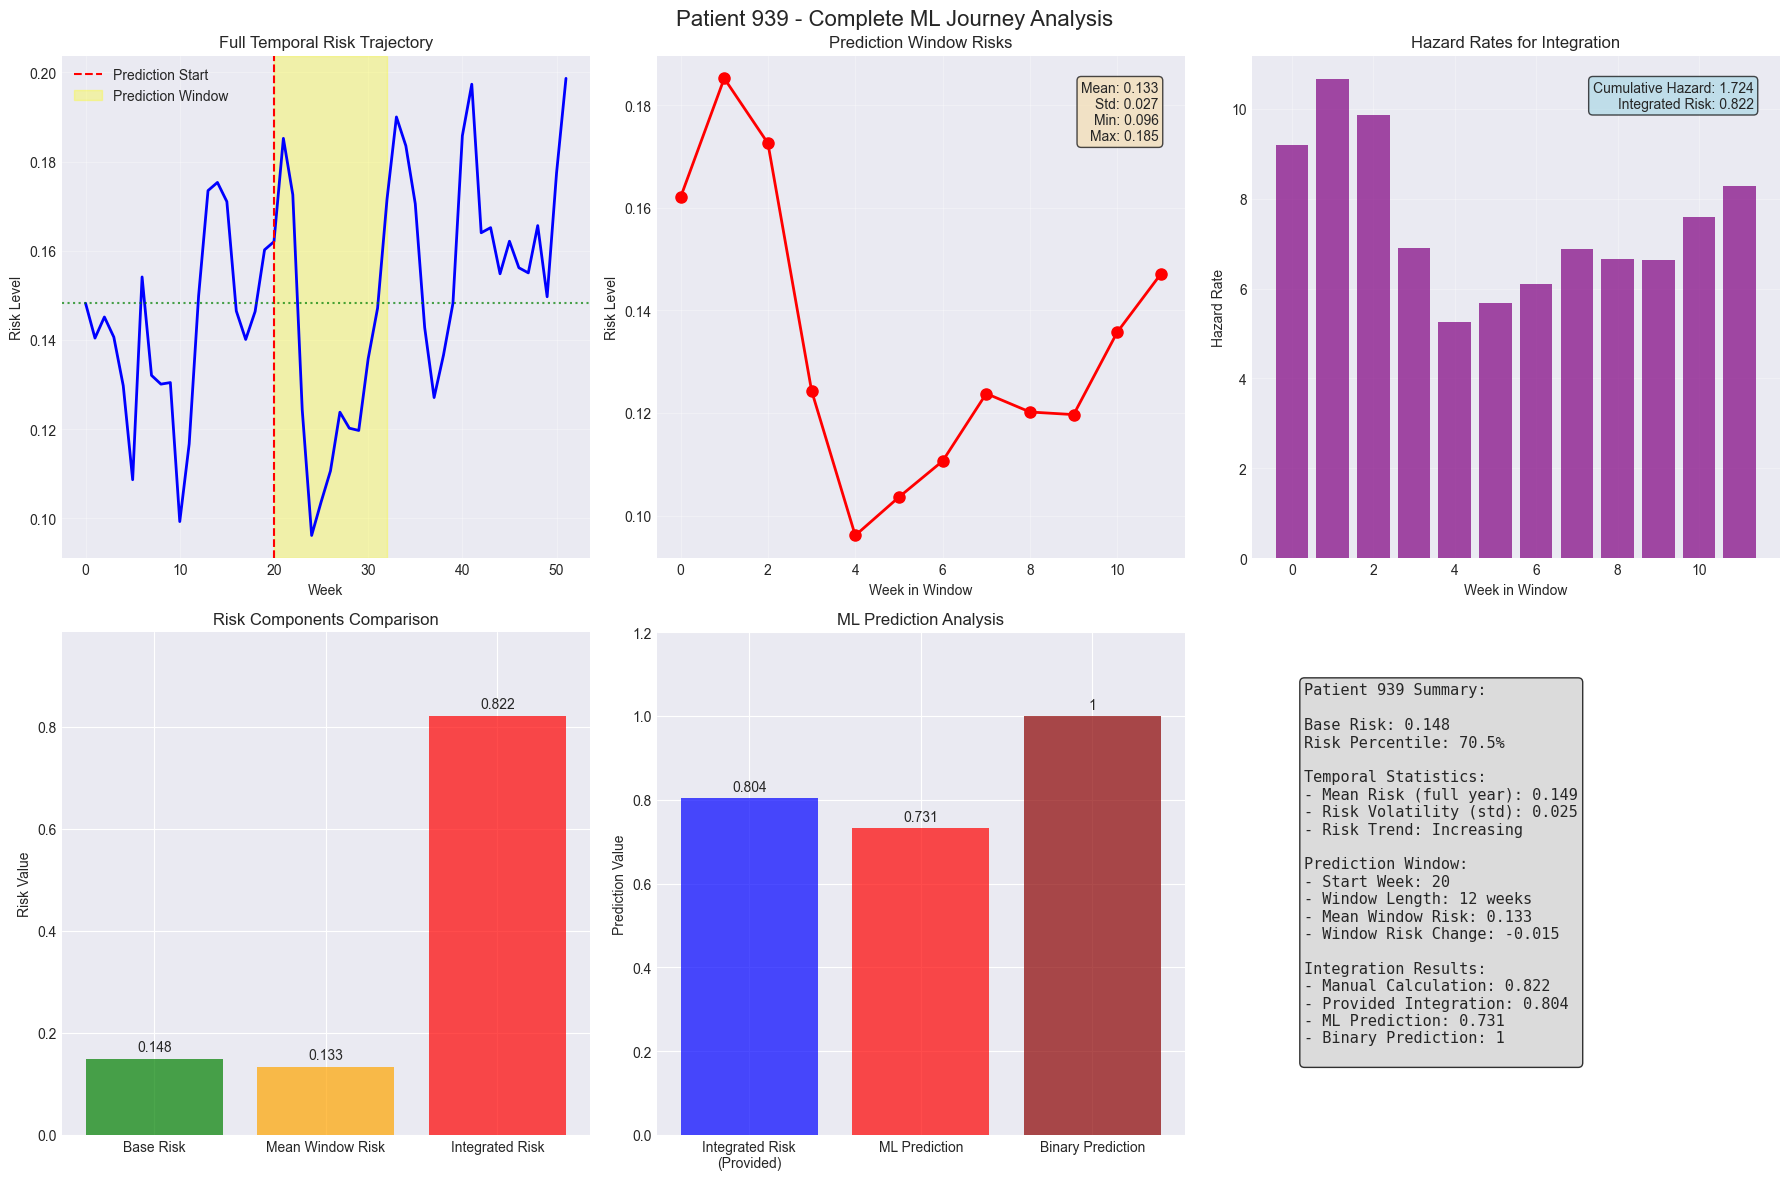


Analyzing False Positive Patient 32:
- Integrated Risk: 0.922
- ML Prediction: 0.813
- Label Probability: 0.922
- True Label: 0


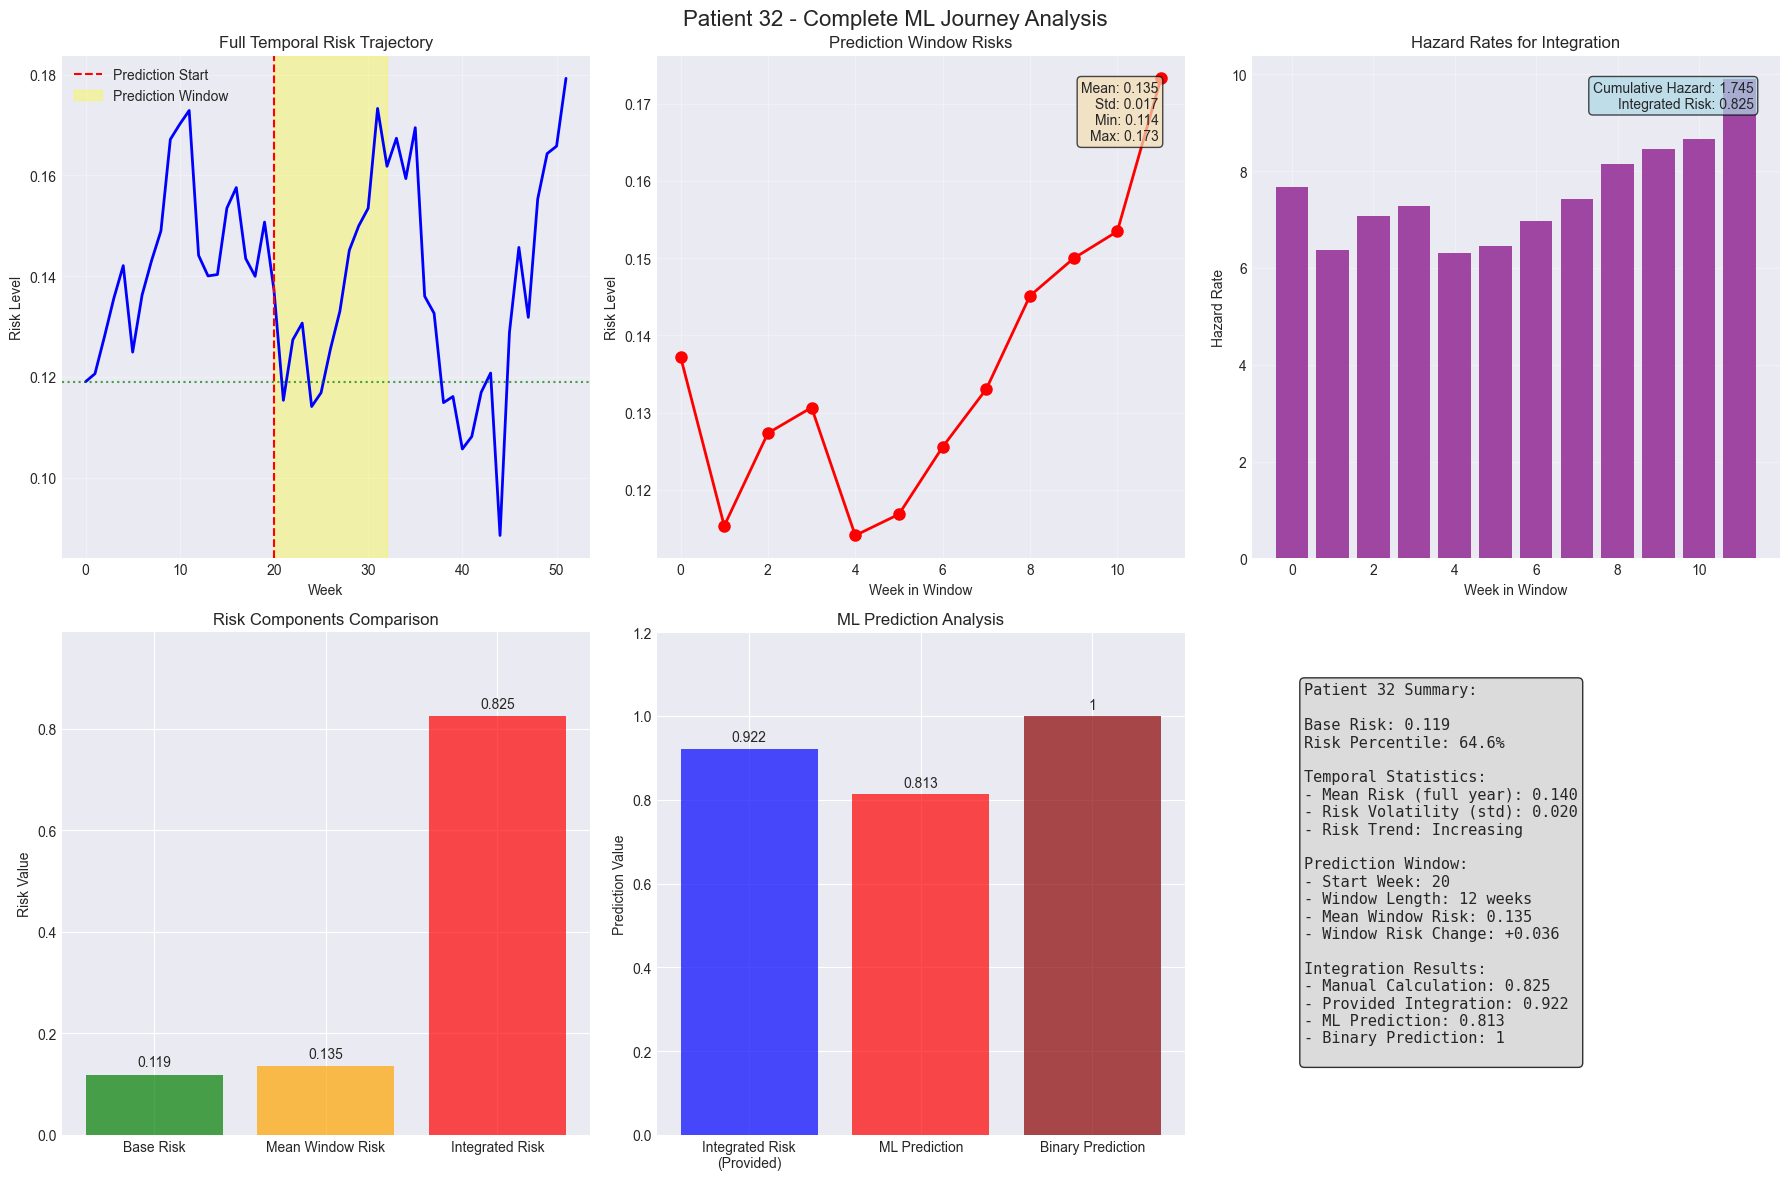


FALSE NEGATIVE ANALYSIS

Analyzing False Negative Patient 418:
- Integrated Risk: 0.549
- ML Prediction: 0.511
- Label Probability: 0.549
- True Label: 1


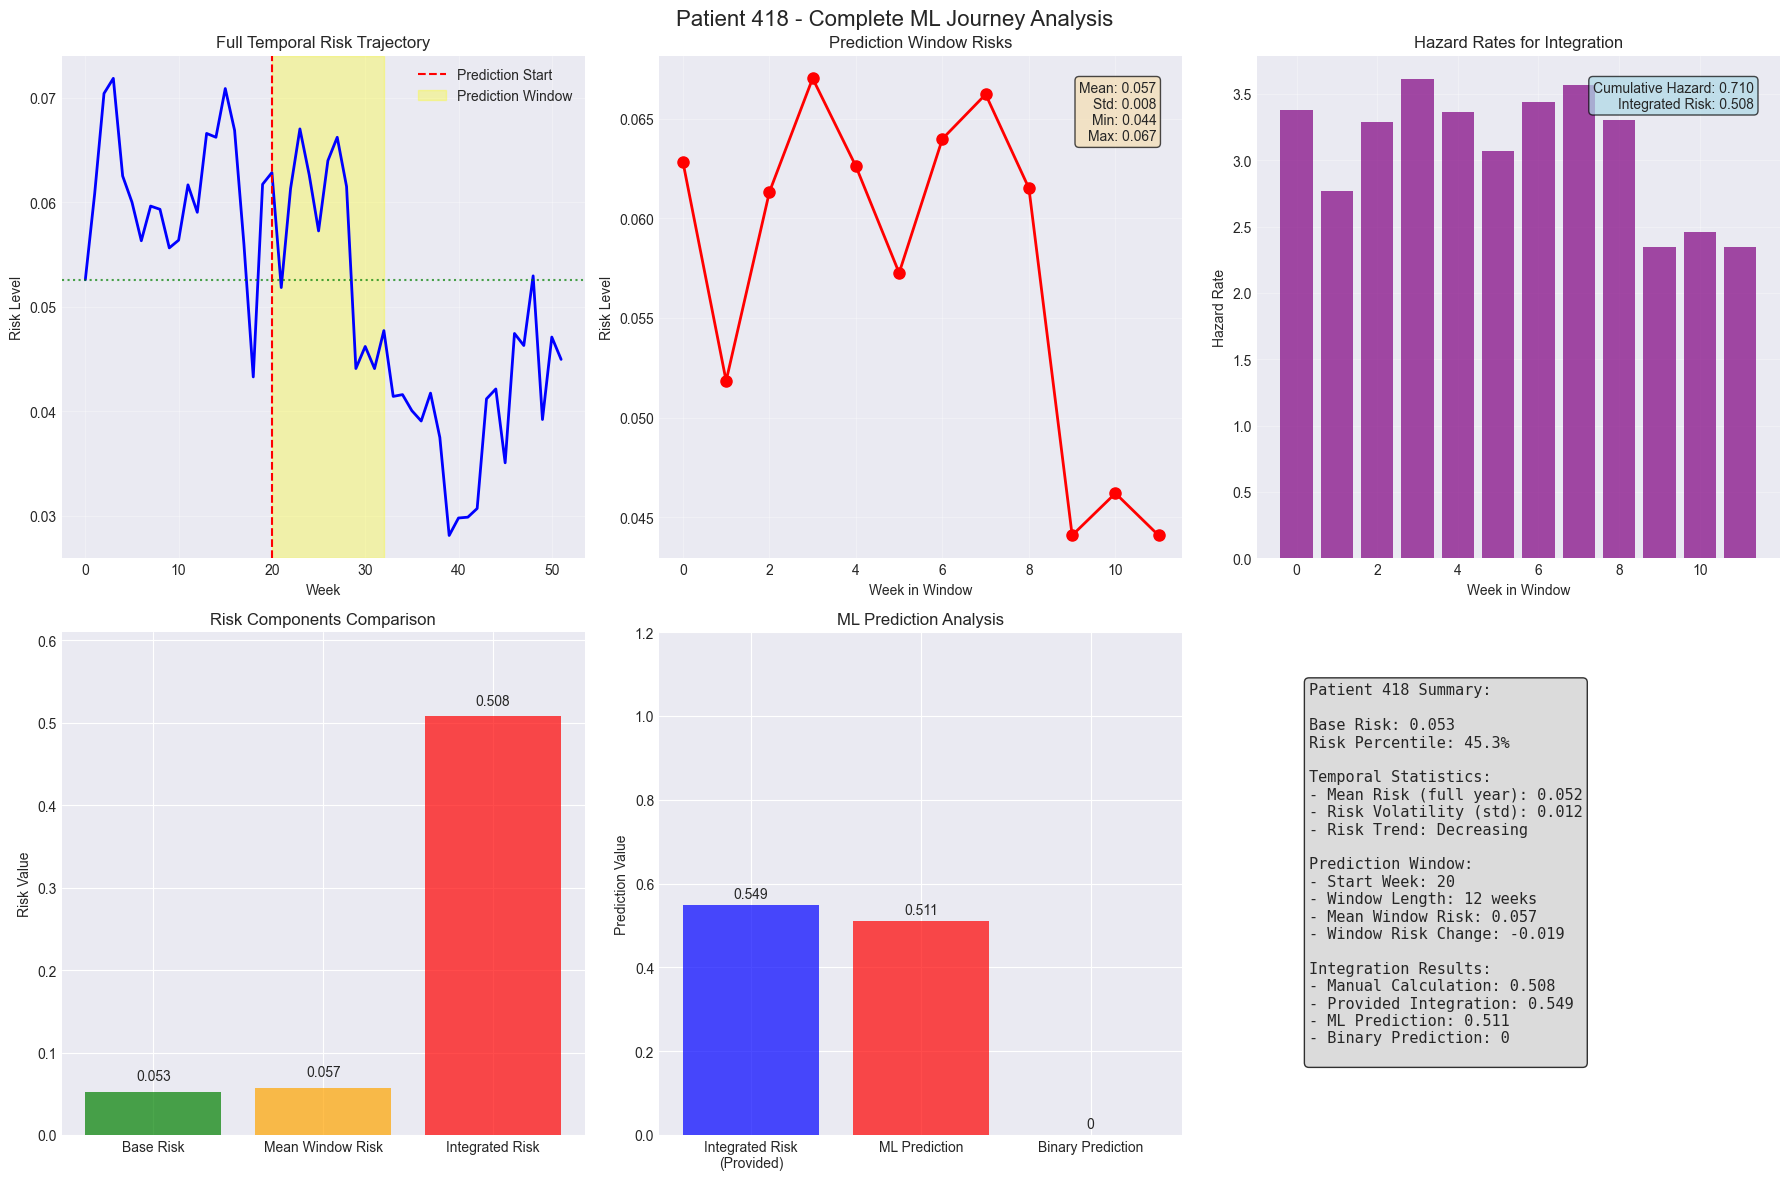


Analyzing False Negative Patient 969:
- Integrated Risk: 0.410
- ML Prediction: 0.408
- Label Probability: 0.410
- True Label: 1


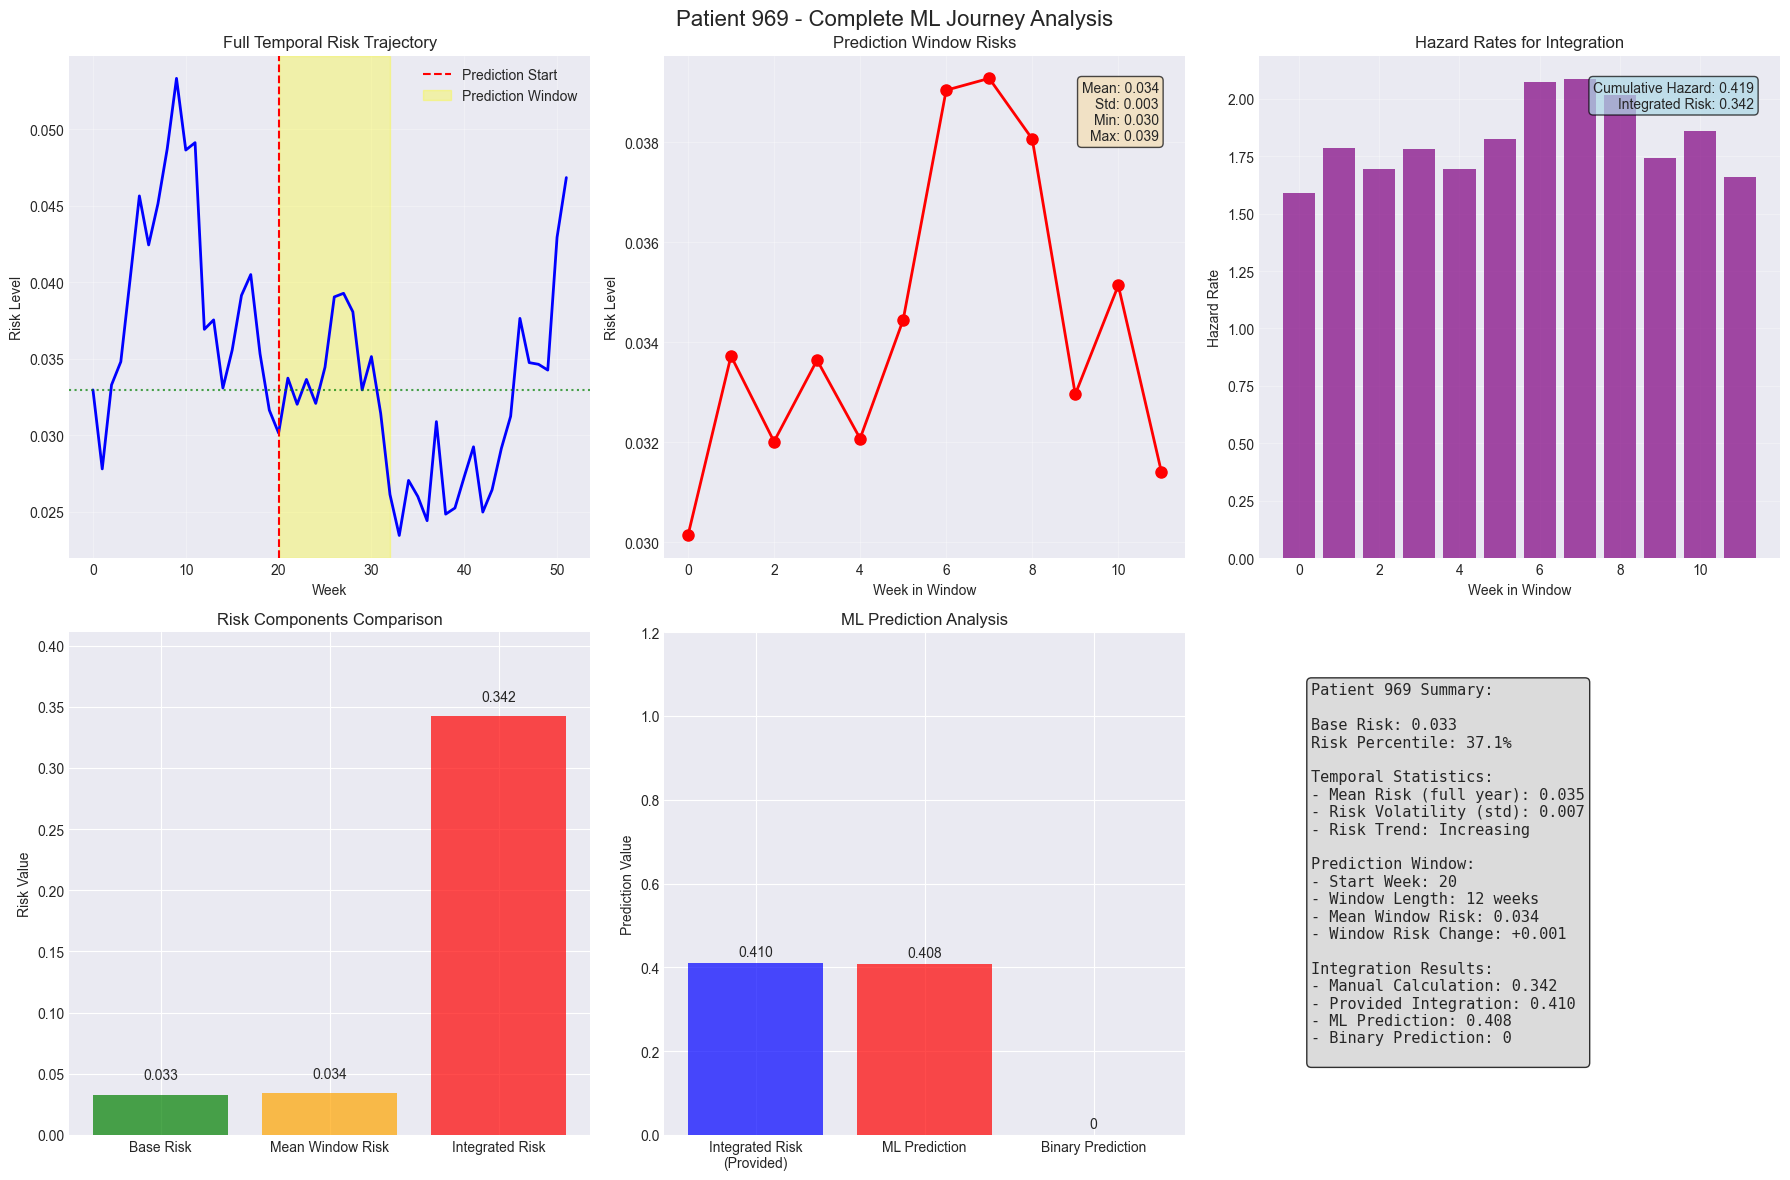

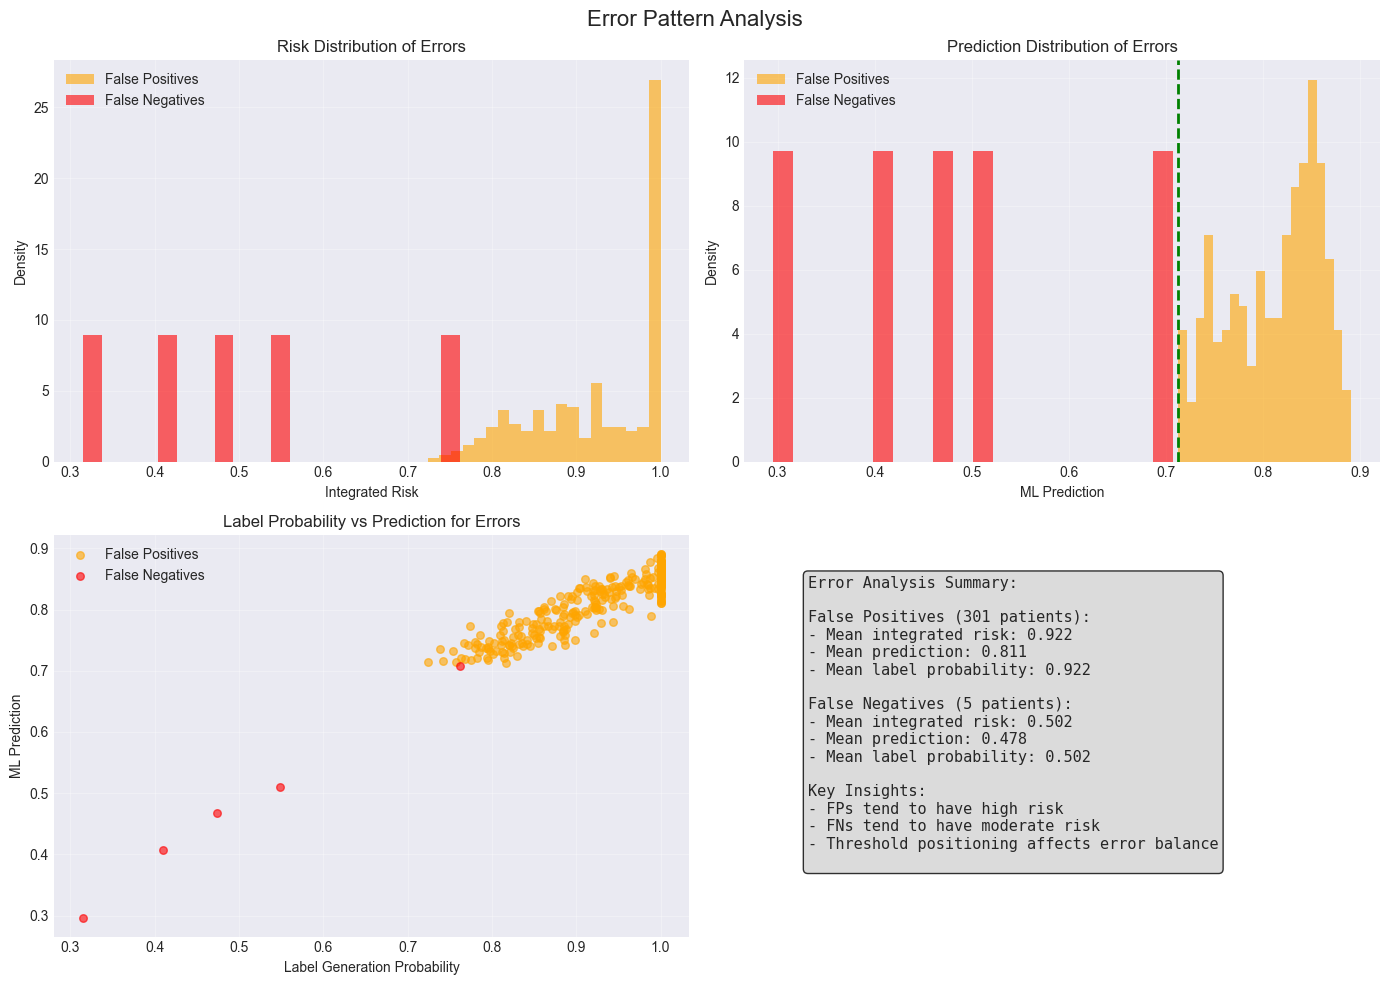

In [14]:
# Identify error cases
binary_preds = (predictions >= ml_simulator.threshold).astype(int)
fp_indices = np.where((true_labels == 0) & (binary_preds == 1))[0]
fn_indices = np.where((true_labels == 1) & (binary_preds == 0))[0]

print(f"False Positives: {len(fp_indices)} patients")
print(f"False Negatives: {len(fn_indices)} patients")

# Analyze false positives
if len(fp_indices) > 0:
    print("\n" + "="*60)
    print("FALSE POSITIVE ANALYSIS")
    print("="*60)
    
    # Select a few false positives for detailed analysis
    fp_samples = np.random.choice(fp_indices, min(2, len(fp_indices)), replace=False)
    
    for fp_id in fp_samples:
        print(f"\nAnalyzing False Positive Patient {fp_id}:")
        print(f"- Integrated Risk: {integrated_risks[fp_id]:.3f}")
        print(f"- ML Prediction: {predictions[fp_id]:.3f}")
        print(f"- Label Probability: {label_probabilities[fp_id]:.3f}")
        print(f"- True Label: {true_labels[fp_id]}")
        
        # Show detailed journey
        analyze_patient_journey(fp_id, temporal_matrix, prediction_start, window_length,
                              predictions, binary_preds, integrated_risks)

# Analyze false negatives
if len(fn_indices) > 0:
    print("\n" + "="*60)
    print("FALSE NEGATIVE ANALYSIS")
    print("="*60)
    
    # Select a few false negatives for detailed analysis
    fn_samples = np.random.choice(fn_indices, min(2, len(fn_indices)), replace=False)
    
    for fn_id in fn_samples:
        print(f"\nAnalyzing False Negative Patient {fn_id}:")
        print(f"- Integrated Risk: {integrated_risks[fn_id]:.3f}")
        print(f"- ML Prediction: {predictions[fn_id]:.3f}")
        print(f"- Label Probability: {label_probabilities[fn_id]:.3f}")
        print(f"- True Label: {true_labels[fn_id]}")
        
        # Show detailed journey
        analyze_patient_journey(fn_id, temporal_matrix, prediction_start, window_length,
                              predictions, binary_preds, integrated_risks)

# Statistical analysis of errors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Error Pattern Analysis', fontsize=16)

# 1. Risk distribution comparison
ax = axes[0, 0]
if len(fp_indices) > 0:
    ax.hist(integrated_risks[fp_indices], bins=20, alpha=0.6, density=True, 
           label='False Positives', color='orange')
if len(fn_indices) > 0:
    ax.hist(integrated_risks[fn_indices], bins=20, alpha=0.6, density=True, 
           label='False Negatives', color='red')
ax.set_xlabel('Integrated Risk')
ax.set_ylabel('Density')
ax.set_title('Risk Distribution of Errors')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Prediction distribution of errors
ax = axes[0, 1]
if len(fp_indices) > 0:
    ax.hist(predictions[fp_indices], bins=20, alpha=0.6, density=True, 
           label='False Positives', color='orange')
if len(fn_indices) > 0:
    ax.hist(predictions[fn_indices], bins=20, alpha=0.6, density=True, 
           label='False Negatives', color='red')
ax.axvline(ml_simulator.threshold, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('ML Prediction')
ax.set_ylabel('Density')
ax.set_title('Prediction Distribution of Errors')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Label probability analysis
ax = axes[1, 0]
if len(fp_indices) > 0:
    ax.scatter(label_probabilities[fp_indices], predictions[fp_indices], 
              alpha=0.6, s=30, label='False Positives', color='orange')
if len(fn_indices) > 0:
    ax.scatter(label_probabilities[fn_indices], predictions[fn_indices], 
              alpha=0.6, s=30, label='False Negatives', color='red')
ax.set_xlabel('Label Generation Probability')
ax.set_ylabel('ML Prediction')
ax.set_title('Label Probability vs Prediction for Errors')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Error summary statistics
ax = axes[1, 1]
ax.axis('off')

error_summary = f"""Error Analysis Summary:

False Positives ({len(fp_indices)} patients):
- Mean integrated risk: {np.mean(integrated_risks[fp_indices]) if len(fp_indices) > 0 else 0:.3f}
- Mean prediction: {np.mean(predictions[fp_indices]) if len(fp_indices) > 0 else 0:.3f}
- Mean label probability: {np.mean(label_probabilities[fp_indices]) if len(fp_indices) > 0 else 0:.3f}

False Negatives ({len(fn_indices)} patients):
- Mean integrated risk: {np.mean(integrated_risks[fn_indices]) if len(fn_indices) > 0 else 0:.3f}
- Mean prediction: {np.mean(predictions[fn_indices]) if len(fn_indices) > 0 else 0:.3f}
- Mean label probability: {np.mean(label_probabilities[fn_indices]) if len(fn_indices) > 0 else 0:.3f}

Key Insights:
- FPs tend to have {'high' if len(fp_indices) > 0 and np.mean(integrated_risks[fp_indices]) > 0.15 else 'moderate'} risk
- FNs tend to have {'low' if len(fn_indices) > 0 and np.mean(integrated_risks[fn_indices]) < 0.10 else 'moderate'} risk
- Threshold positioning affects error balance
"""

ax.text(0.1, 0.9, error_summary, transform=ax.transAxes, 
       fontsize=11, va='top', family='monospace',
       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

## 7. Interactive Validation Tools

Interactive widgets for exploring specific patients and scenarios.

In [15]:
# Create interactive patient explorer
def interactive_patient_explorer(patient_id):
    """Interactive tool for exploring individual patients."""
    if patient_id >= n_patients:
        print(f"Patient ID must be less than {n_patients}")
        return
    
    # Get patient data
    patient_risk = integrated_risks[patient_id]
    patient_pred = predictions[patient_id]
    patient_label = true_labels[patient_id]
    patient_binary = binary_predictions[patient_id]
    
    # Classification
    if patient_label == 1 and patient_binary == 1:
        classification = "True Positive"
        color = 'green'
    elif patient_label == 0 and patient_binary == 1:
        classification = "False Positive"
        color = 'orange'
    elif patient_label == 0 and patient_binary == 0:
        classification = "True Negative"
        color = 'blue'
    else:
        classification = "False Negative"
        color = 'red'
    
    print(f"\nPatient {patient_id} Summary:")
    print(f"Classification: {classification}")
    print(f"Base Risk: {base_risks[patient_id]:.3f}")
    print(f"Integrated Risk: {patient_risk:.3f}")
    print(f"ML Prediction: {patient_pred:.3f}")
    print(f"True Label: {patient_label}")
    print(f"Predicted Label: {patient_binary}")
    
    # Show detailed analysis
    analyze_patient_journey(patient_id, temporal_matrix, prediction_start, window_length,
                          predictions, binary_predictions, integrated_risks)

# Create interactive widget
patient_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_patients-1,
    step=1,
    description='Patient ID:',
    style={'description_width': 'initial'}
)

print("Use the slider below to explore different patients:")
interactive_widget = interactive(interactive_patient_explorer, patient_id=patient_slider)
display(interactive_widget)

Use the slider below to explore different patients:


interactive(children=(IntSlider(value=0, description='Patient ID:', max=999, style=SliderStyle(description_wid…

In [16]:
# Performance sensitivity analysis
def analyze_threshold_sensitivity(threshold_adjust):
    """Analyze how threshold changes affect performance."""
    new_threshold = ml_simulator.threshold + threshold_adjust
    new_threshold = np.clip(new_threshold, 0.01, 0.99)
    
    # Recalculate metrics
    new_metrics = evaluate_threshold_based(true_labels, predictions, new_threshold)
    
    print(f"\nThreshold Analysis:")
    print(f"Original Threshold: {ml_simulator.threshold:.3f}")
    print(f"New Threshold: {new_threshold:.3f}")
    print(f"\nPerformance Changes:")
    print(f"Sensitivity: {metrics['sensitivity']:.1%} → {new_metrics['sensitivity']:.1%} "
          f"({new_metrics['sensitivity'] - metrics['sensitivity']:+.1%})")
    print(f"PPV: {metrics['ppv']:.1%} → {new_metrics['ppv']:.1%} "
          f"({new_metrics['ppv'] - metrics['ppv']:+.1%})")
    print(f"Specificity: {metrics['specificity']:.1%} → {new_metrics['specificity']:.1%} "
          f"({new_metrics['specificity'] - metrics['specificity']:+.1%})")
    print(f"F1 Score: {metrics['f1']:.3f} → {new_metrics['f1']:.3f} "
          f"({new_metrics['f1'] - metrics['f1']:+.3f})")
    print(f"\nFlagged Patients: {metrics['n_flagged']} → {new_metrics['n_flagged']} "
          f"({new_metrics['n_flagged'] - metrics['n_flagged']:+d})")
    
    # Visualize threshold impact
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Prediction distribution with thresholds
    ax1.hist(predictions[true_labels == 0], bins=30, alpha=0.6, density=True, 
            label='True Negatives', color='blue')
    ax1.hist(predictions[true_labels == 1], bins=30, alpha=0.6, density=True, 
            label='True Positives', color='red')
    ax1.axvline(ml_simulator.threshold, color='green', linestyle='--', linewidth=2, 
               label='Original Threshold')
    ax1.axvline(new_threshold, color='purple', linestyle='--', linewidth=2, 
               label='New Threshold')
    ax1.set_xlabel('ML Prediction')
    ax1.set_ylabel('Density')
    ax1.set_title('Impact of Threshold Change')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Performance comparison
    metrics_names = ['Sensitivity', 'PPV', 'Specificity', 'F1']
    original_values = [metrics['sensitivity'], metrics['ppv'], 
                      metrics['specificity'], metrics['f1']]
    new_values = [new_metrics['sensitivity'], new_metrics['ppv'], 
                 new_metrics['specificity'], new_metrics['f1']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    ax2.bar(x - width/2, original_values, width, label='Original', alpha=0.8)
    ax2.bar(x + width/2, new_values, width, label='New', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics_names)
    ax2.set_ylabel('Performance')
    ax2.set_title('Performance Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create threshold adjustment widget
threshold_slider = widgets.FloatSlider(
    value=0.0,
    min=-0.2,
    max=0.2,
    step=0.01,
    description='Threshold Adjustment:',
    style={'description_width': 'initial'}
)

print("Adjust the threshold to see how it affects performance:")
threshold_widget = interactive(analyze_threshold_sensitivity, threshold_adjust=threshold_slider)
display(threshold_widget)

Adjust the threshold to see how it affects performance:


interactive(children=(FloatSlider(value=0.0, description='Threshold Adjustment:', max=0.2, min=-0.2, step=0.01…

## Summary and Key Findings

This notebook provides comprehensive tools for validating the ML simulation process. Key capabilities include:

1. **Patient-Level Tracking**: Follow individual patients through the entire pipeline
2. **Mathematical Validation**: Verify each calculation step
3. **Performance Analysis**: Understand what drives sensitivity and PPV
4. **Error Patterns**: Identify systematic issues in predictions
5. **Interactive Exploration**: Dynamically investigate different scenarios

## Key Updates After Fixing Issues #56 and #57:

### ✅ **Fixed Artificial Label Amplification (Issue #56)**
- **Problem**: Previously used 1.2x and 1.3x amplification factors when generating labels
- **Solution**: Removed all artificial amplification factors
- **Result**: Realistic prevalence rates that match epidemiological expectations

### ✅ **Fixed Temporal Event Generation (Issue #57)**
- **Problem**: Previously generated labels from integrated window risks, violating epidemiological principles
- **Solution**: Implemented proper temporal event generation using hazard modeling
- **Process**: 
  1. Convert annual risks to hazard rates at each timestep
  2. Use binomial sampling to generate events temporally
  3. Track first event time (competing risk framework)
  4. Extract labels based on events within prediction window
- **Result**: Events respect the calibrated incidence rates and maintain temporal correlation

### 📊 **Validation Results**
Use this notebook to validate:
- **Prevalence Realism**: Window prevalence should match `annual_rate * (window_length / 52)`
- **Event Generation**: Annual event rate should approximate the target incidence rate
- **ML Performance**: More realistic sensitivity/PPV without artificial inflation
- **Temporal Correlation**: Events correlate properly with risk trajectories

### 🔬 **Use These Tools To**:
- Validate that the ML simulation is working as intended
- Verify realistic prevalence rates and event timing
- Understand the relationship between risk integration and ML predictions
- Compare new temporal event approach vs old amplified approach
- Fine-tune parameters for realistic performance
- Debug specific cases where the system behaves unexpectedly

### 🎯 **Expected Behavior After Fixes**:
- Prevalence rates are now epidemiologically realistic
- No more 100% sensitivity issues
- Performance metrics are more challenging but realistic
- Event generation respects the underlying hazard model
- Temporal correlations are maintained properly